In [2]:
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn import preprocessing 
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedShuffleSplit, GridSearchCV
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer,KNNImputer
import seaborn as sns
import matplotlib.pyplot as plt

# Download data

In [3]:
data = pd.read_csv('./data/orange_small_churn_train_data.csv')

In [4]:
data.head()

,ID,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,labels
0,0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,...,vr93T2a,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,NaN,-1.0
1,1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,...,6hQ9lNX,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,NaN,-1.0
2,2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,NaN,-1.0
3,3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,...,e4lqvY0,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN,1.0
4,4,NaN,NaN,NaN,NaN,NaN,686.0,7.0,NaN,NaN,...,MAz3HNj,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN,-1.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18299 entries, 0 to 18298
Columns: 232 entries, ID to labels
dtypes: float64(192), int64(2), object(38)
memory usage: 32.4+ MB


In [6]:
# check null in features
dict_nan = {name: np.sum(data[name].isnull()) for name in data.columns}
dict_nan

{'ID': 0,
 'Var1': 18038,
 'Var2': 17831,
 'Var3': 17832,
 'Var4': 17736,
 'Var5': 17799,
 'Var6': 1991,
 'Var7': 1976,
 'Var8': 18299,
 'Var9': 18038,
 'Var10': 17799,
 'Var11': 17832,
 'Var12': 18085,
 'Var13': 1976,
 'Var14': 17832,
 'Var15': 18299,
 'Var16': 17799,
 'Var17': 17736,
 'Var18': 17736,
 'Var19': 17736,
 'Var20': 18299,
 'Var21': 1991,
 'Var22': 1792,
 'Var23': 17799,
 'Var24': 2616,
 'Var25': 1792,
 'Var26': 17799,
 'Var27': 17799,
 'Var28': 1793,
 'Var29': 18038,
 'Var30': 18038,
 'Var31': 18299,
 'Var32': 18299,
 'Var33': 18010,
 'Var34': 17831,
 'Var35': 1792,
 'Var36': 17831,
 'Var37': 17736,
 'Var38': 1792,
 'Var39': 18299,
 'Var40': 17831,
 'Var41': 18038,
 'Var42': 18299,
 'Var43': 17831,
 'Var44': 1792,
 'Var45': 18171,
 'Var46': 17831,
 'Var47': 18038,
 'Var48': 18299,
 'Var49': 17831,
 'Var50': 18038,
 'Var51': 16888,
 'Var52': 18299,
 'Var53': 18038,
 'Var54': 17831,
 'Var55': 18299,
 'Var56': 18055,
 'Var57': 0,
 'Var58': 18038,
 'Var59': 17990,
 'Var60': 1

In [7]:
# check disbalance in classes
print(data['labels'].value_counts())
print(data['labels'].unique())

-1.0    16921
 1.0     1377
Name: labels, dtype: int64
[-1.  1. nan]


In [8]:
data['labels'].replace(-1, 0, inplace=True)
data.dropna(subset=['labels'], inplace=True)
labels = data['labels']
data = data.iloc[:,:-1]

In [9]:
# # balance class by undersampling
# count_add = int((len(labels[labels == 0]) - len(labels[labels == 1]))*0.7)
# index_for_balance = labels[labels == 1].index
# add_index = np.random.choice(index_for_balance, size = count_add)
# data_add = data.iloc[add_index]
# labels_add = labels.iloc[add_index]

# data = pd.concat([data, data_add])
# labels = pd.concat([labels, labels_add])

In [10]:
# # balanced
# count_add = int((len(labels[labels == 0]) - len(labels[labels == 1]))*0.7)
# index_for_balance = labels[labels == 0].index
# drop_index = np.random.choice(index_for_balance, size = count_add, replace=False)

# data.drop(index=drop_index, inplace=True)
# labels.drop(index=drop_index, inplace=True)

In [11]:
labels.value_counts()

0.0    16921
1.0     1377
Name: labels, dtype: int64

# Simple preprocessing feature

In [12]:
# drop feture with null more half of dataset
def check_feat_without(data, columns, threshold = 0):
    flag_nan_col = [np.sum(data[name].isnull()) < threshold for name in columns]
    return columns[flag_nan_col]
    

In [13]:
numeric_col = data.columns[1:190]
cat_col = data.columns[190:]
print(len(numeric_col))
print(len(cat_col))

189
41


In [14]:
right_numeric_column = check_feat_without(data, numeric_col, threshold = len(data)//2)
right_cat_column = check_feat_without(data, cat_col, threshold = len(data)//2)
print(len(right_numeric_column))
print(len(right_cat_column))

41
28


In [15]:
# check unique in cat feat
for cur_cat in right_cat_column:
    count_uniq = len(data[cur_cat].unique())
    print(f'{cur_cat}: {count_uniq}')

Var192: 326
Var193: 44
Var195: 21
Var196: 4
Var197: 207
Var198: 2721
Var199: 2639
Var202: 4673
Var203: 4
Var204: 100
Var205: 4
Var206: 22
Var207: 12
Var208: 3
Var210: 6
Var211: 2
Var212: 71
Var216: 1247
Var217: 7944
Var218: 3
Var219: 20
Var220: 2721
Var221: 7
Var222: 2721
Var223: 5
Var226: 23
Var227: 7
Var228: 29


In [16]:
# check unique in num feat
for cur_num in right_numeric_column:
    count_uniq = len(data[cur_num].unique())
    print(f'{cur_num}: {count_uniq}')

Var6: 1039
Var7: 7
Var13: 1877
Var21: 498
Var22: 498
Var24: 63
Var25: 190
Var28: 2513
Var35: 10
Var38: 11908
Var44: 6
Var57: 14013
Var65: 13
Var72: 9
Var73: 129
Var74: 284
Var76: 11377
Var78: 13
Var81: 15952
Var83: 130
Var85: 109
Var94: 8571
Var109: 149
Var112: 158
Var113: 17900
Var119: 1003
Var123: 191
Var125: 6217
Var126: 52
Var132: 18
Var133: 14165
Var134: 12639
Var140: 1859
Var143: 5
Var144: 11
Var149: 7524
Var153: 14567
Var160: 273
Var163: 9049
Var173: 4
Var181: 7


Visualisathion numeric

In [17]:
#sns.pairplot(data[right_numeric_column])

In [18]:
corr_map = data[right_numeric_column].corr(method='spearman')

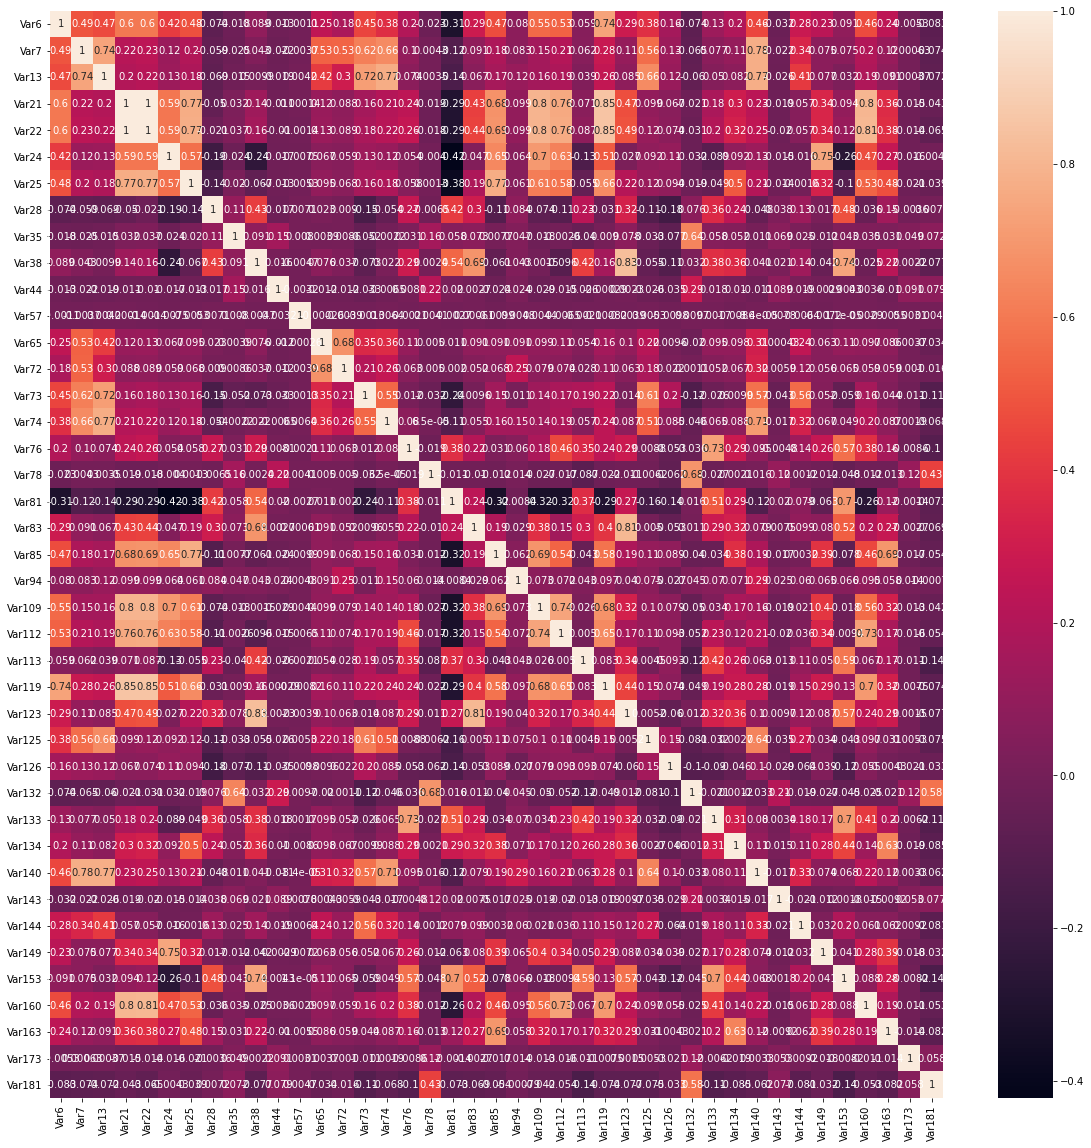

In [19]:
plt.figure(figsize=(20,20))
sns.heatmap(corr_map, annot=True)
plt.show()

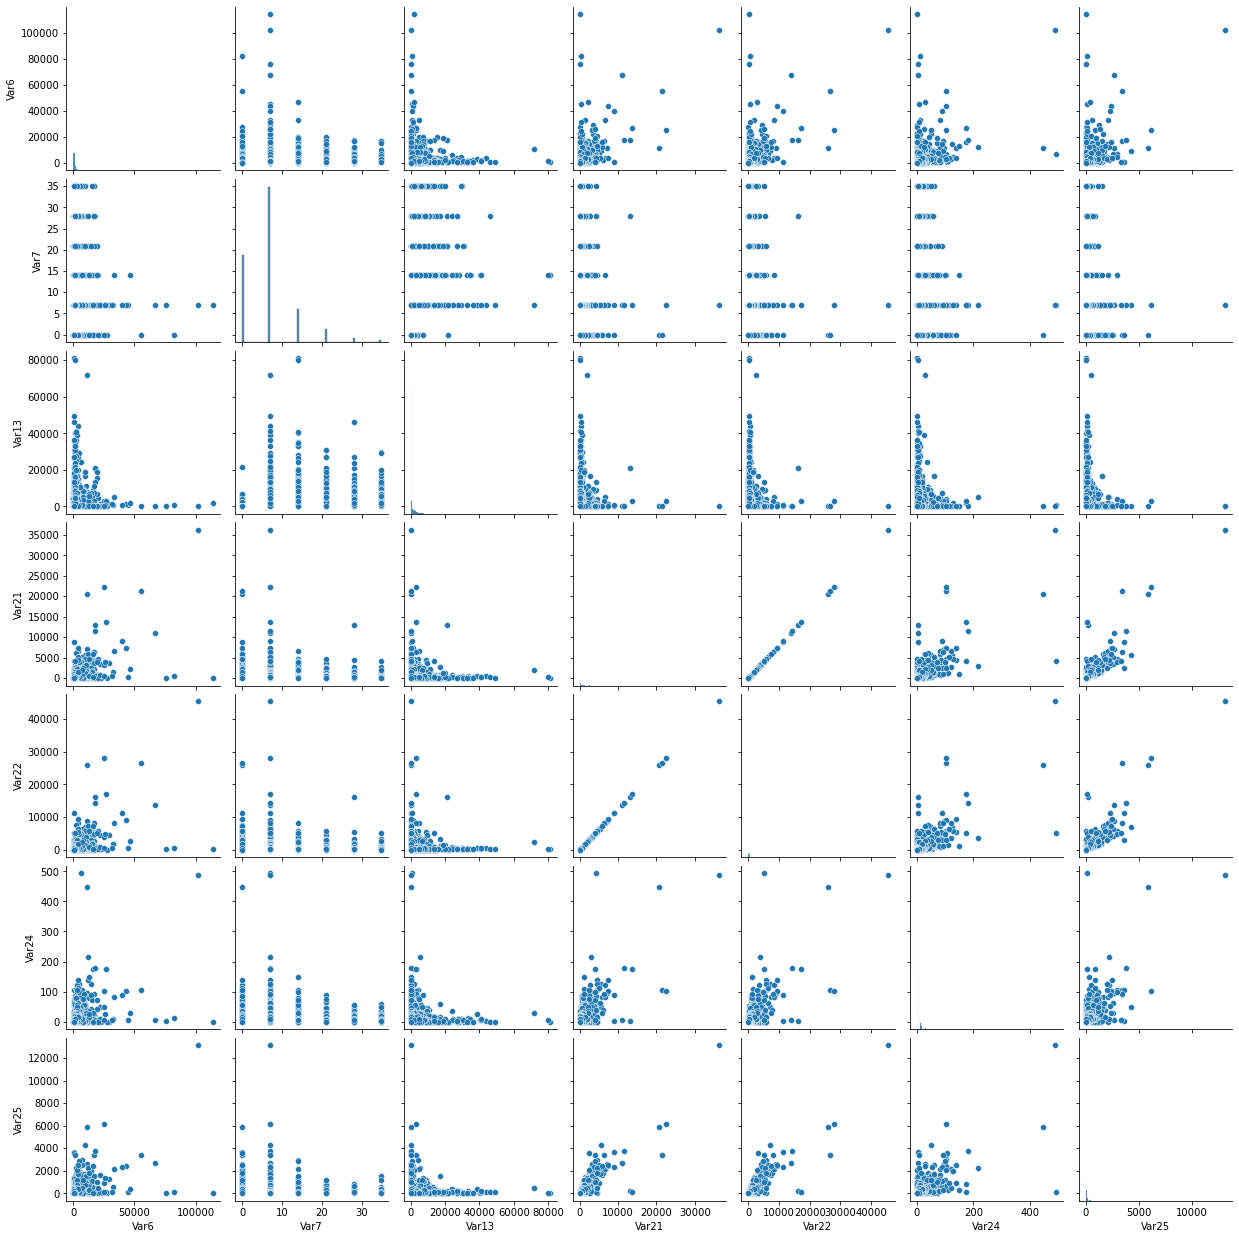

In [20]:
sns.pairplot(data[right_numeric_column[:7]])

var 21 and 22 are very dependet features. Anyway there are some features with large corr we can do choice feature in the future

In [21]:
# cat feature

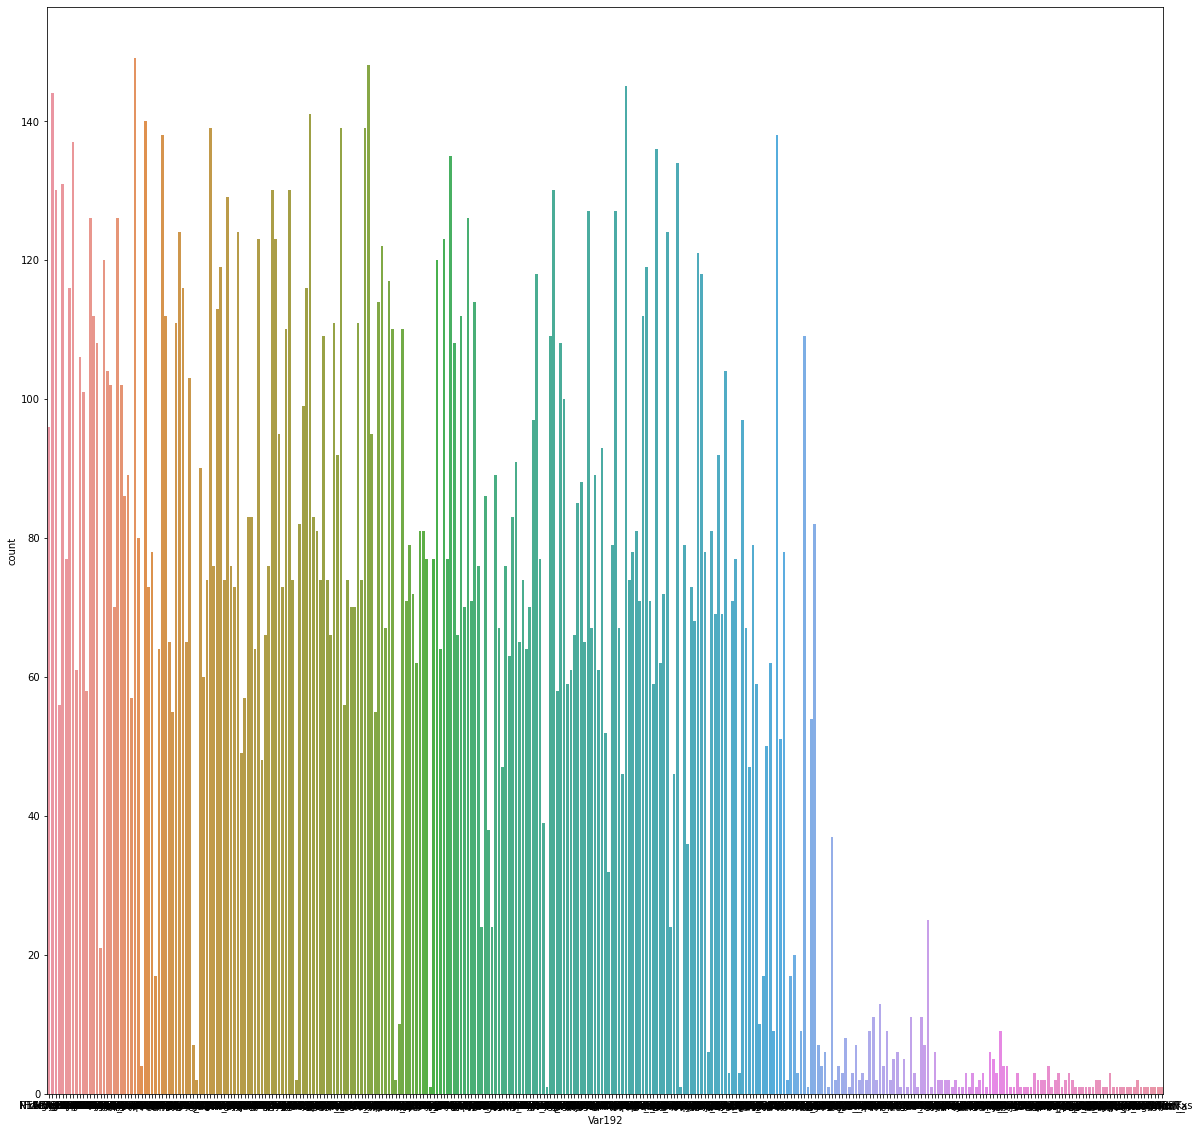

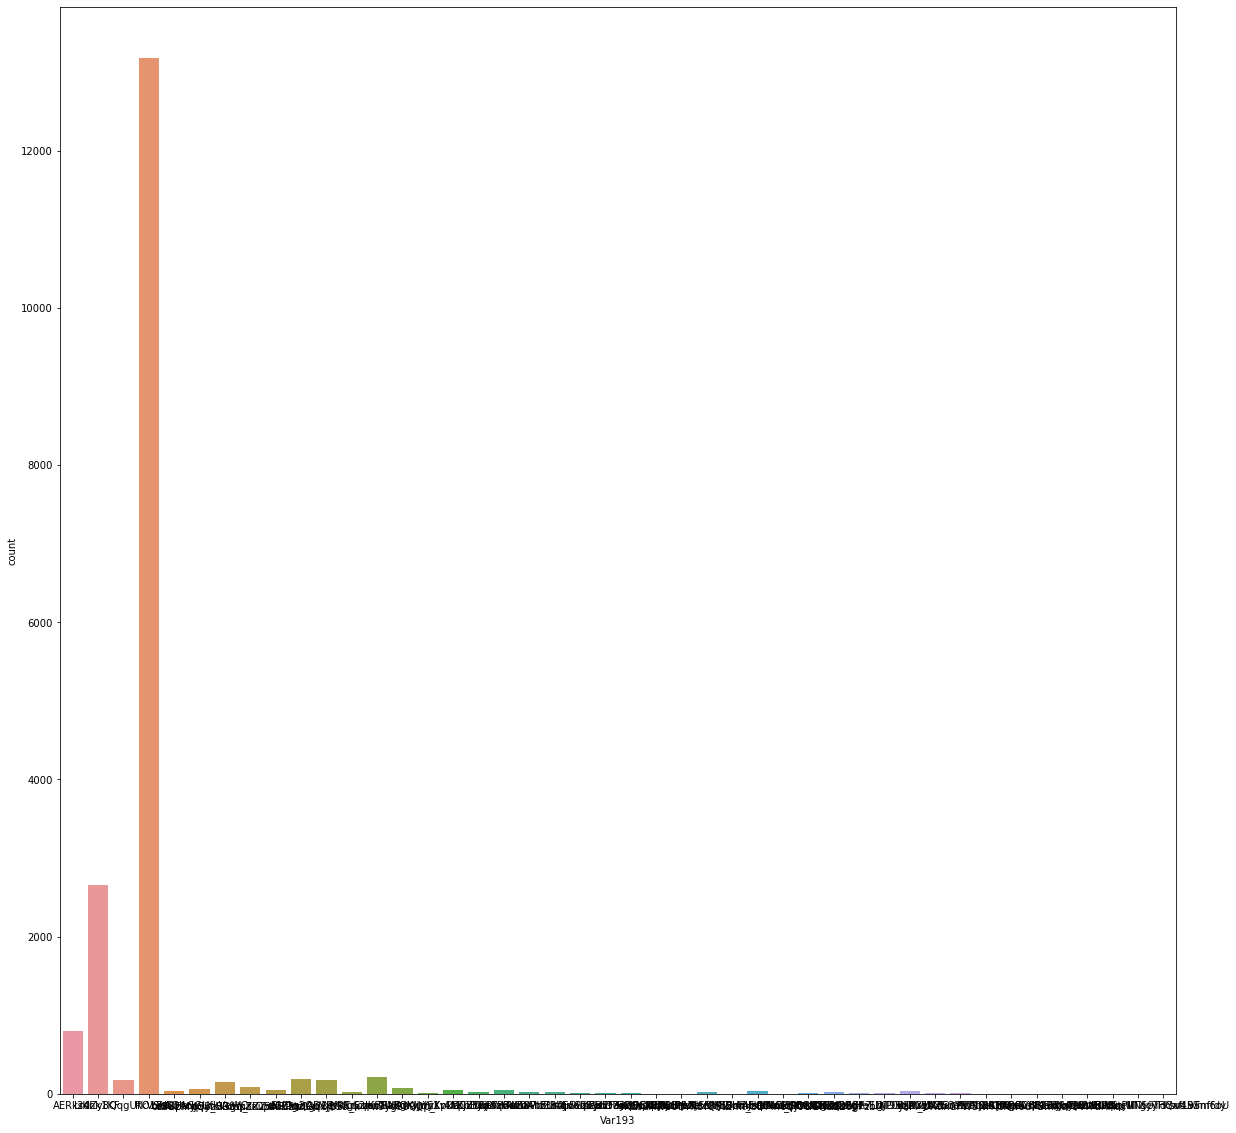

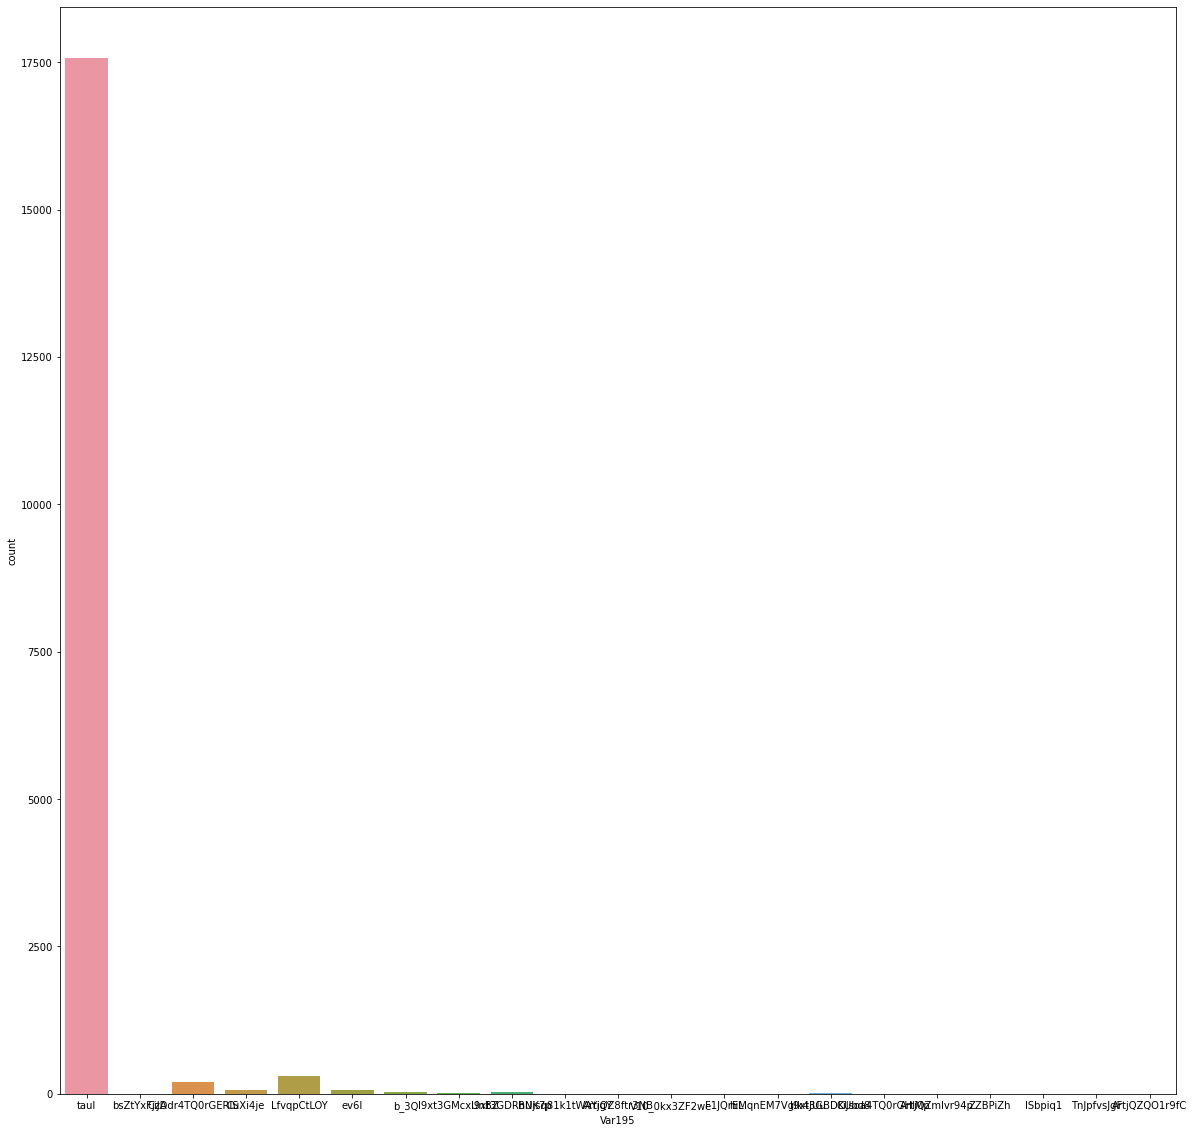

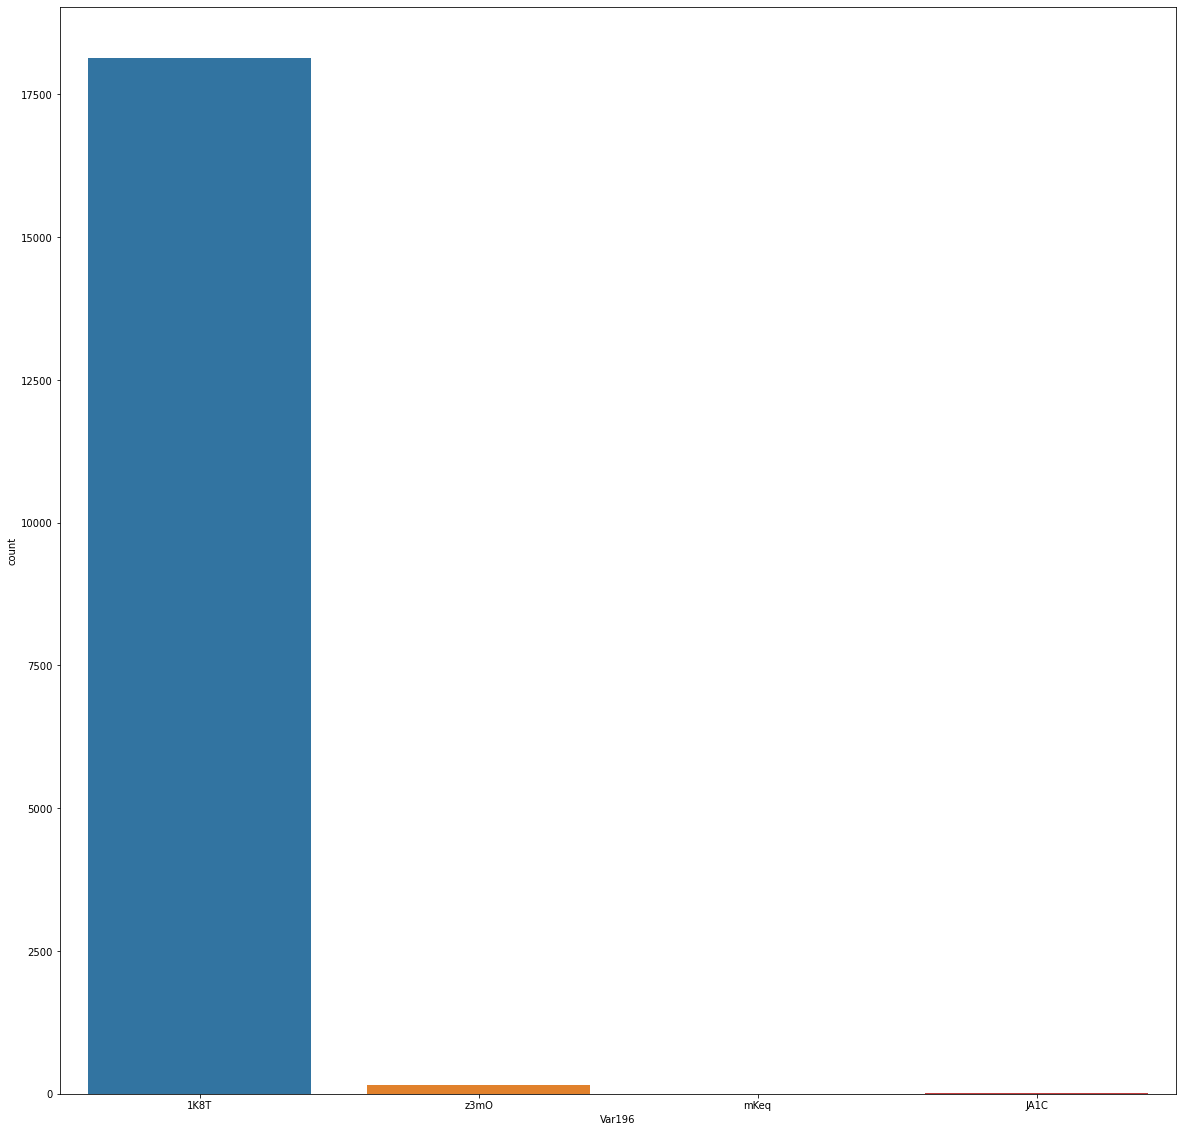

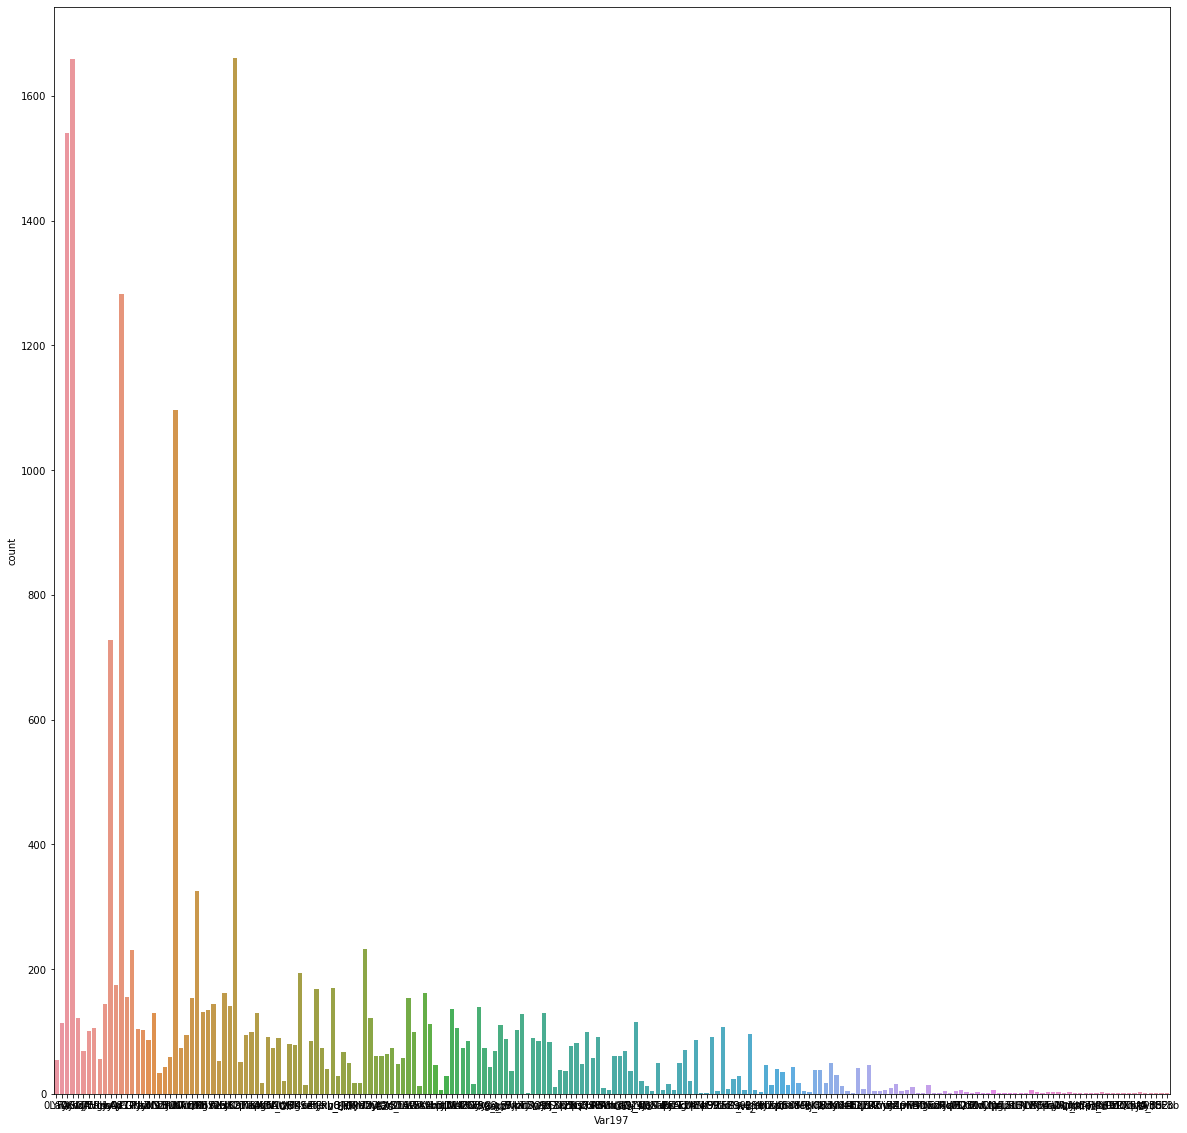

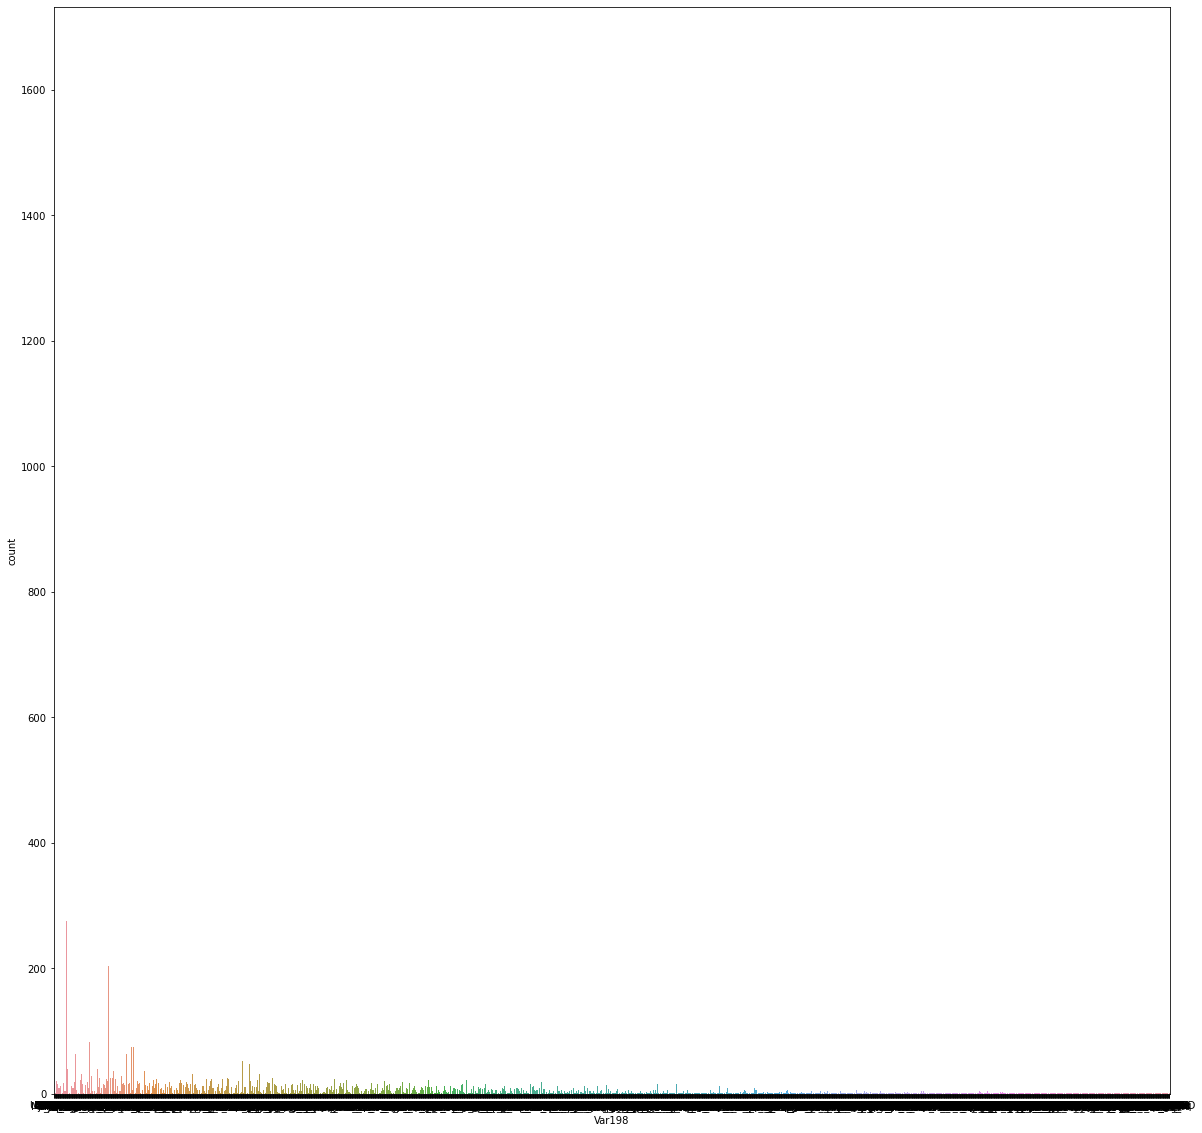

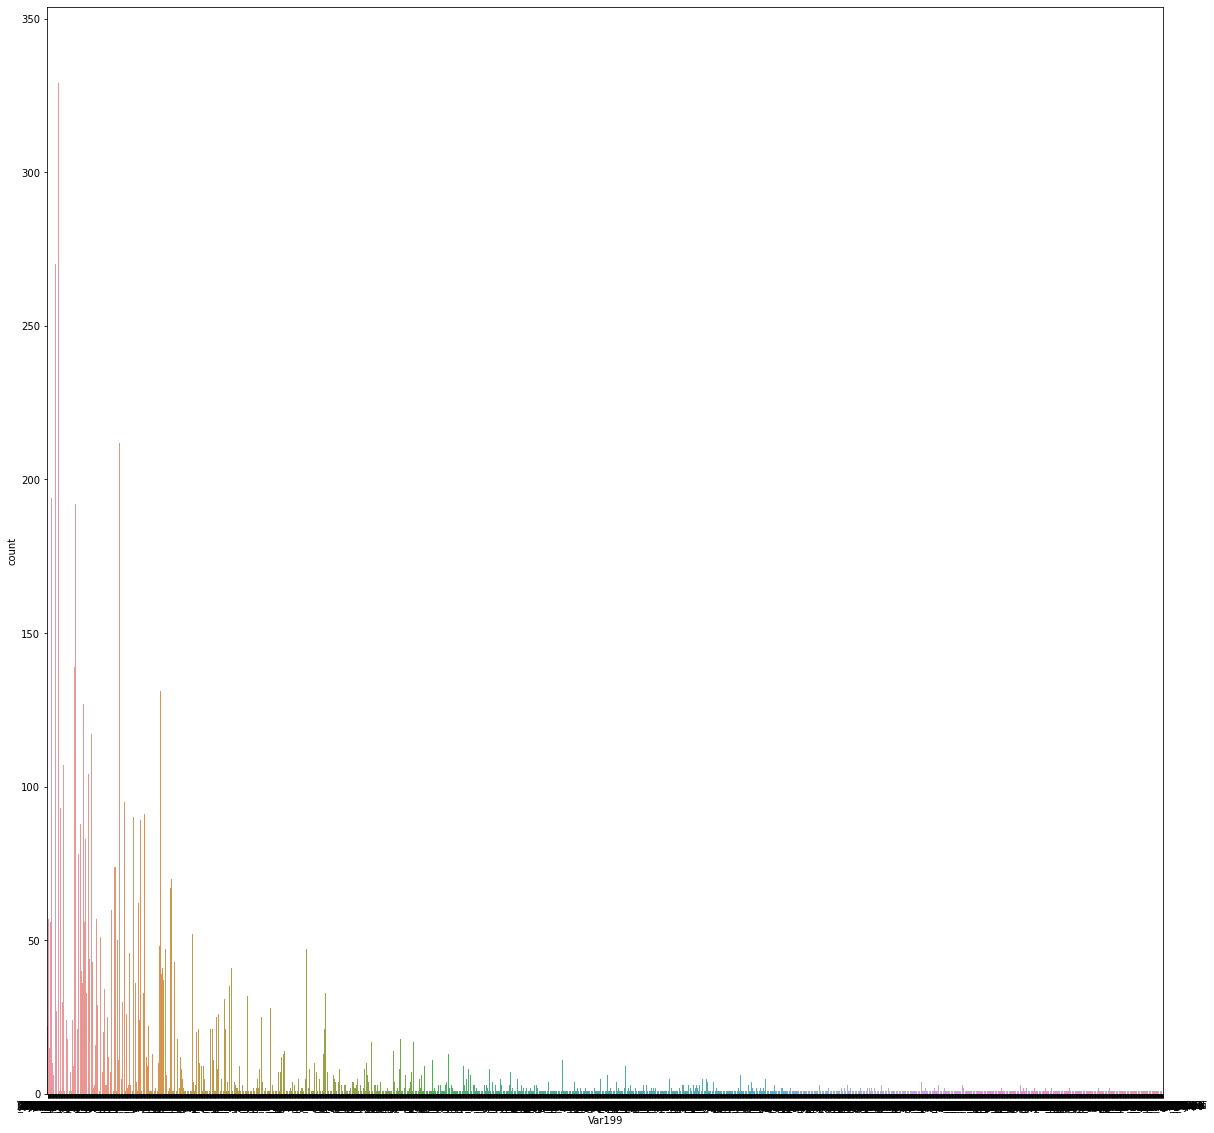

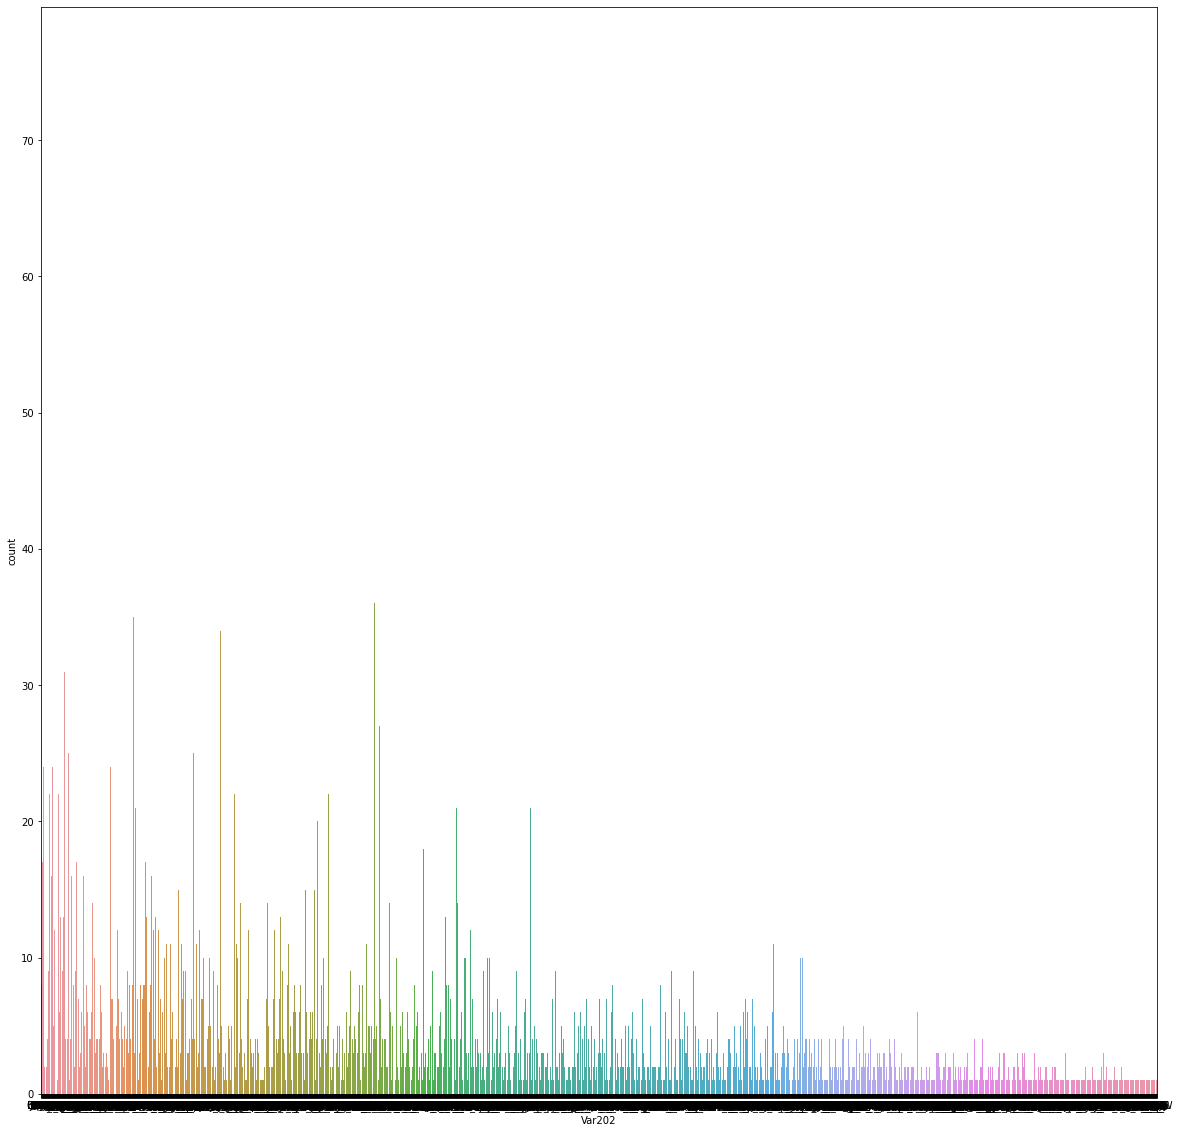

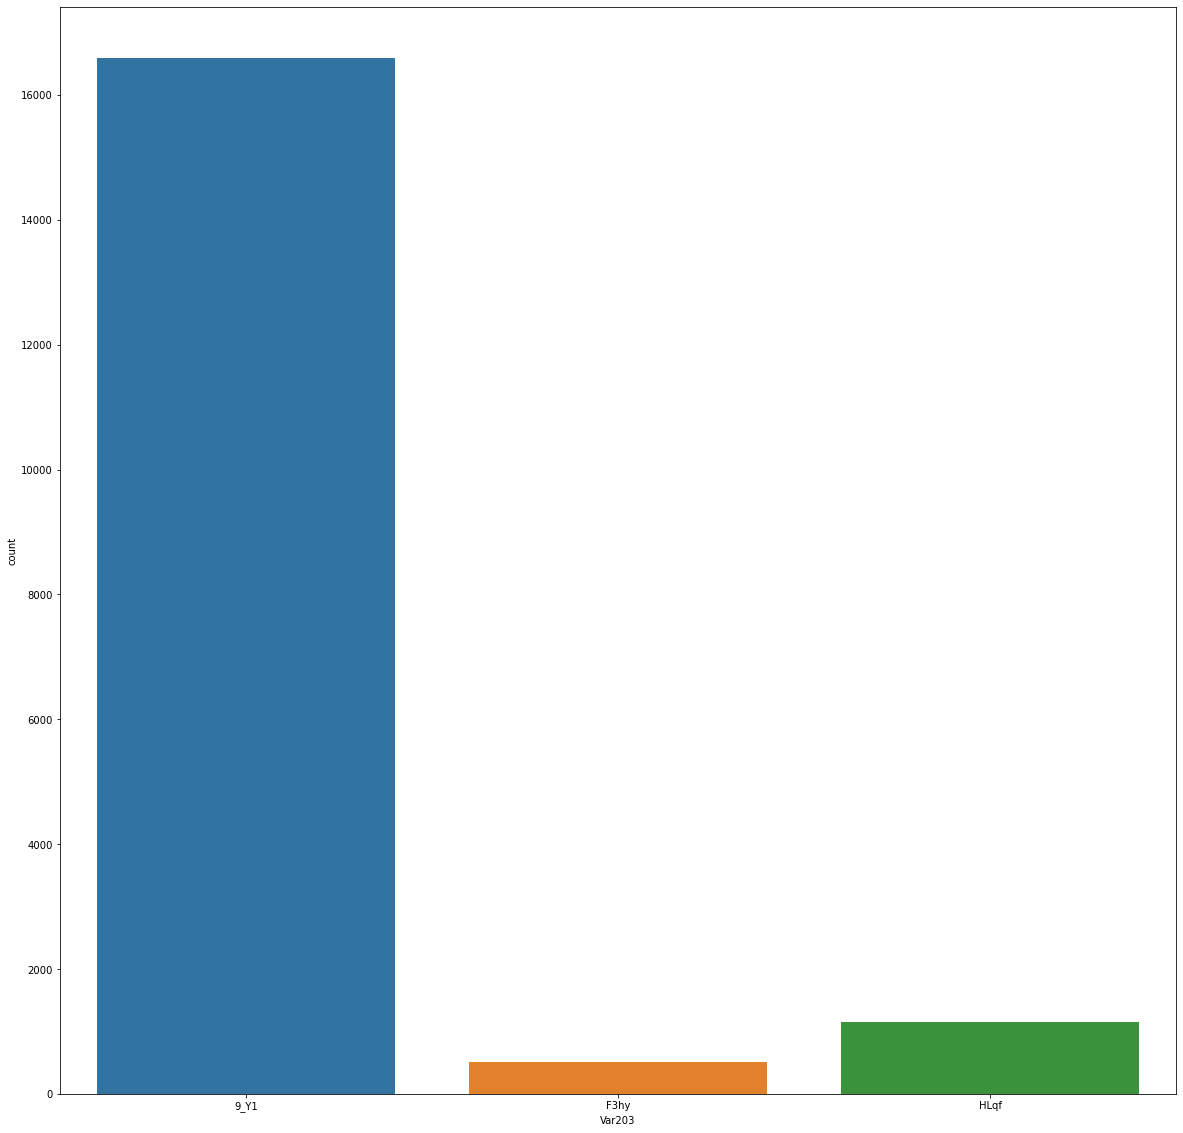

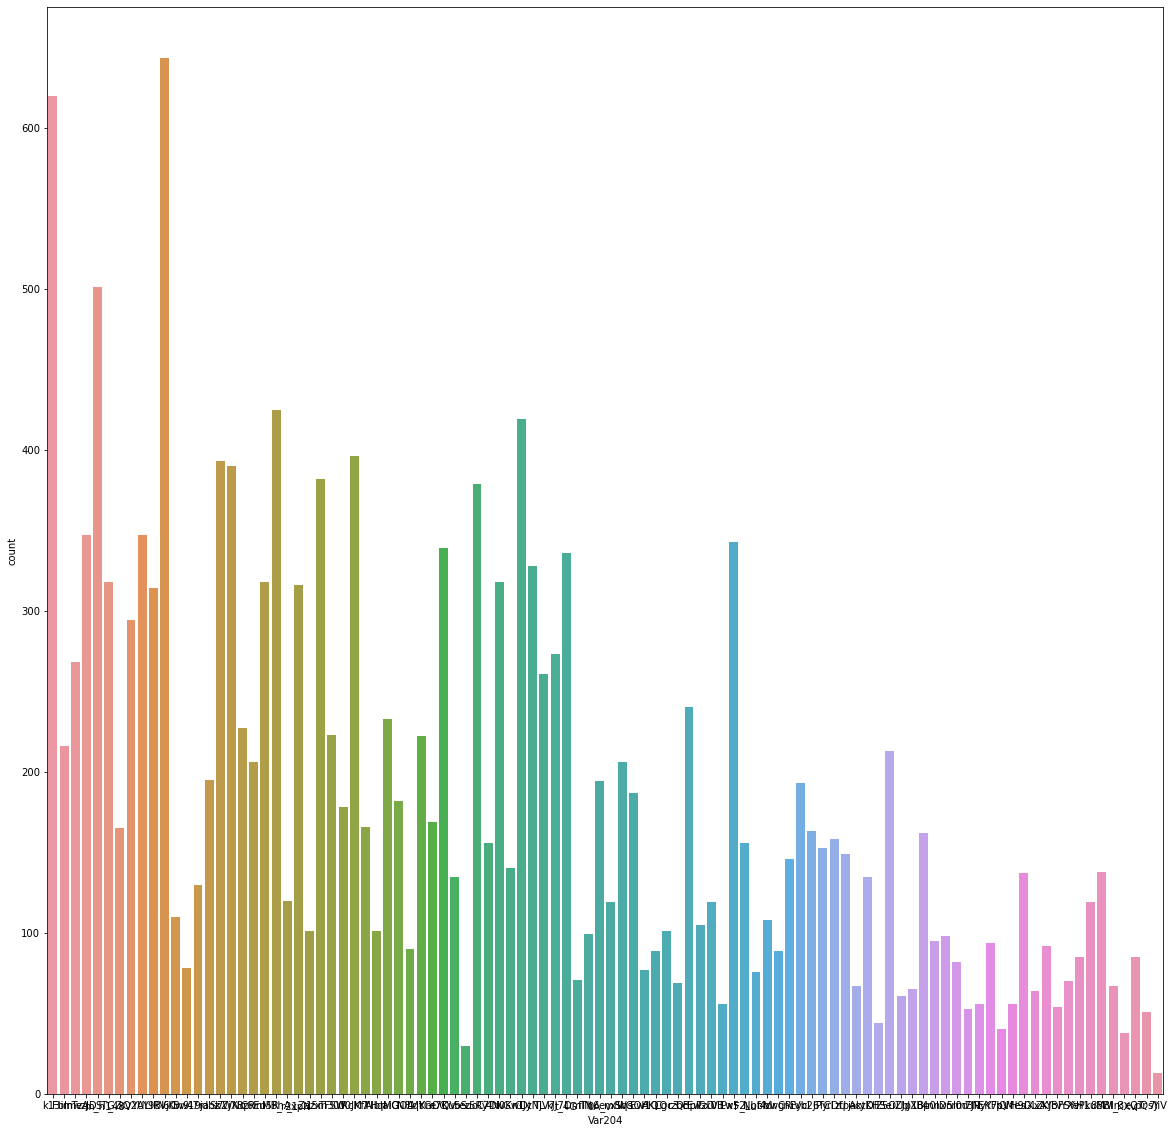

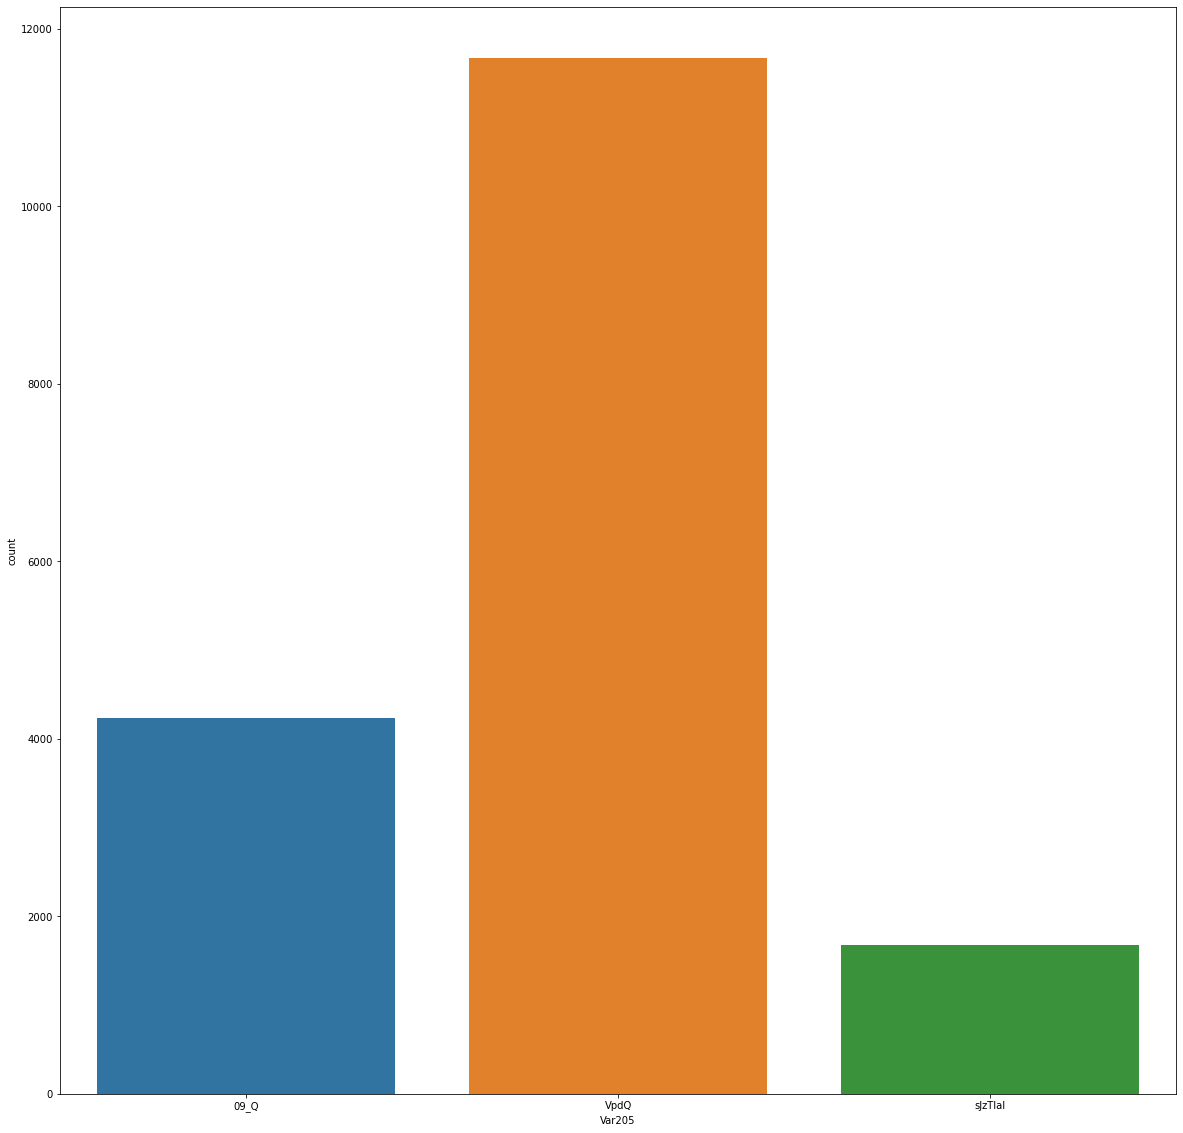

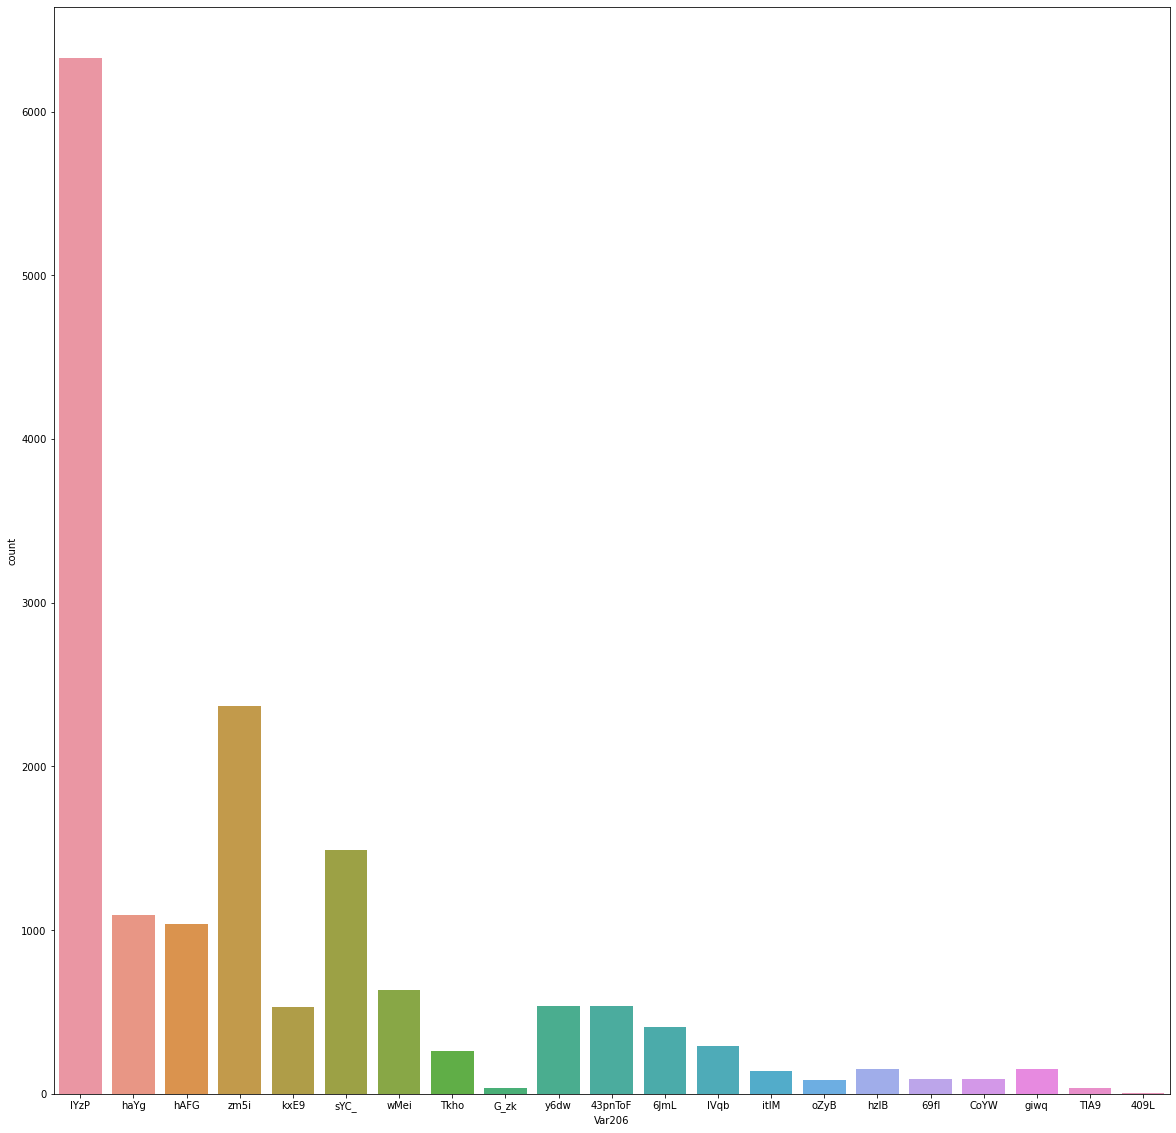

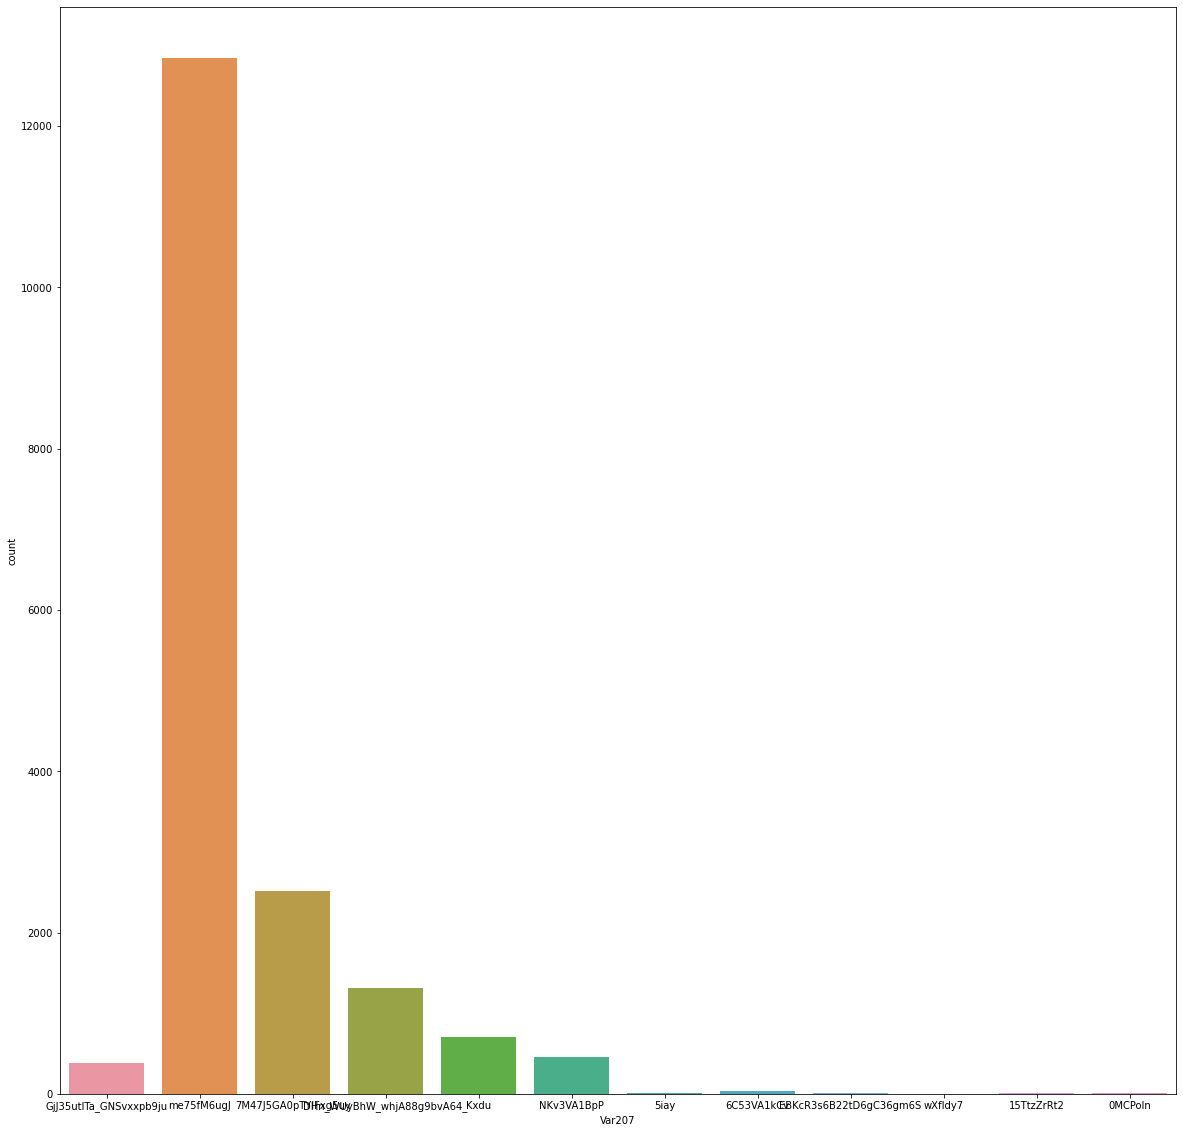

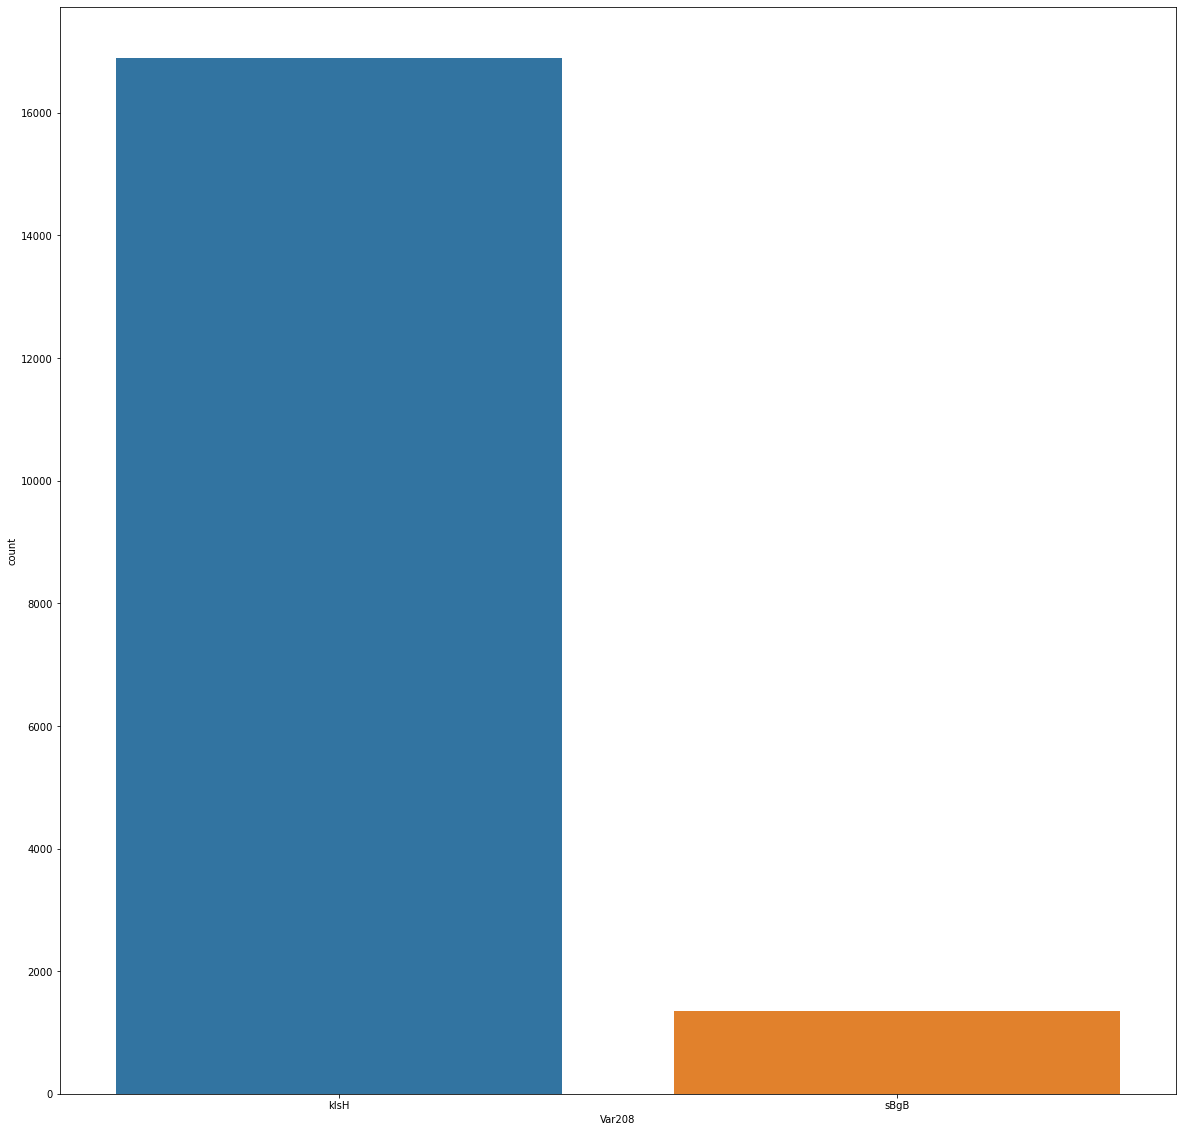

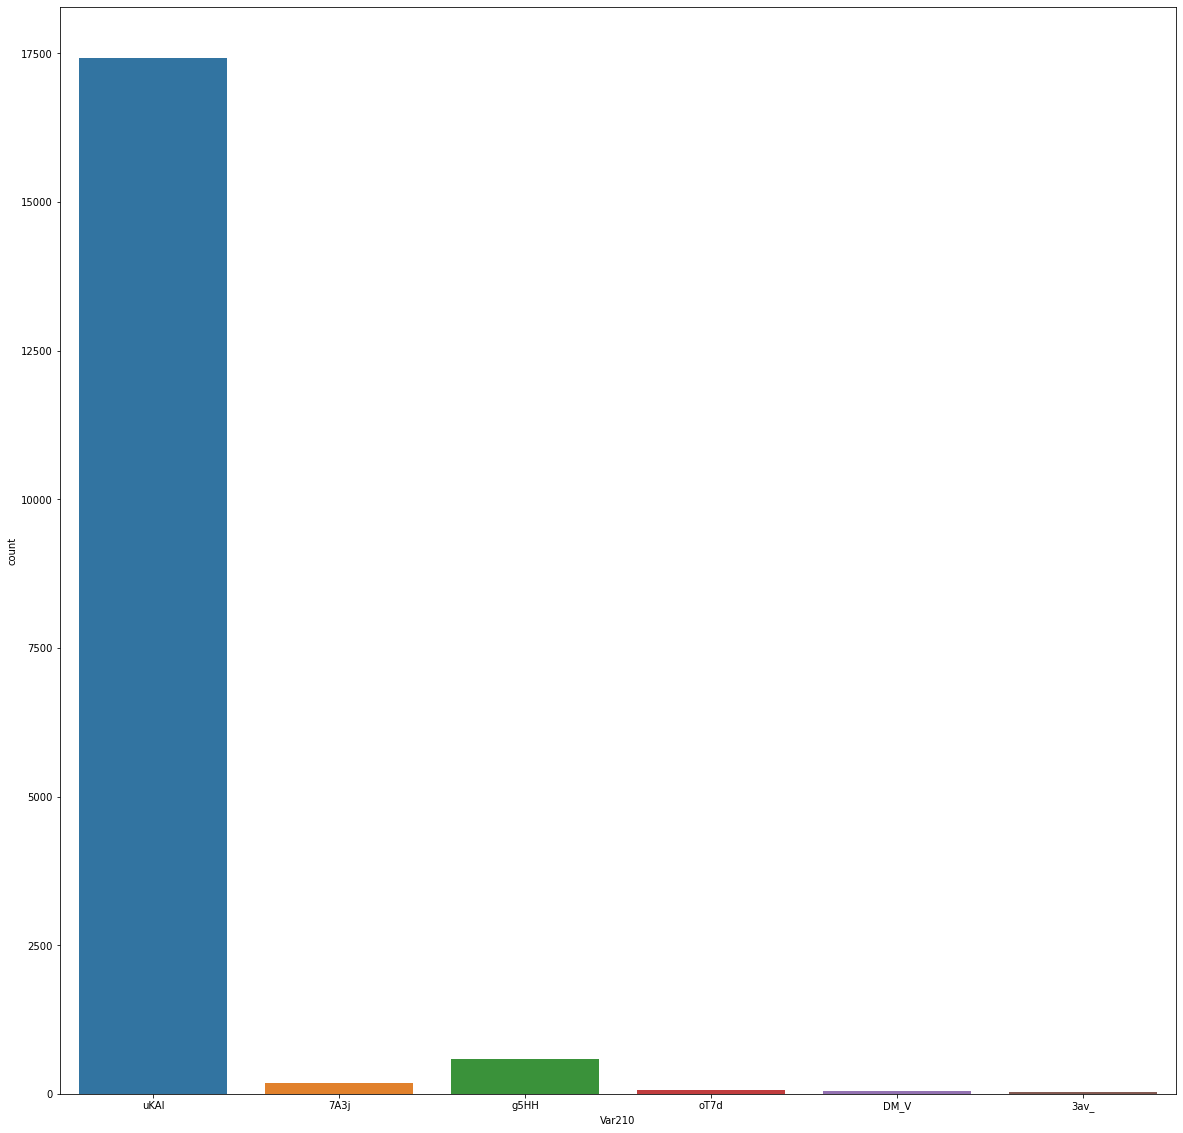

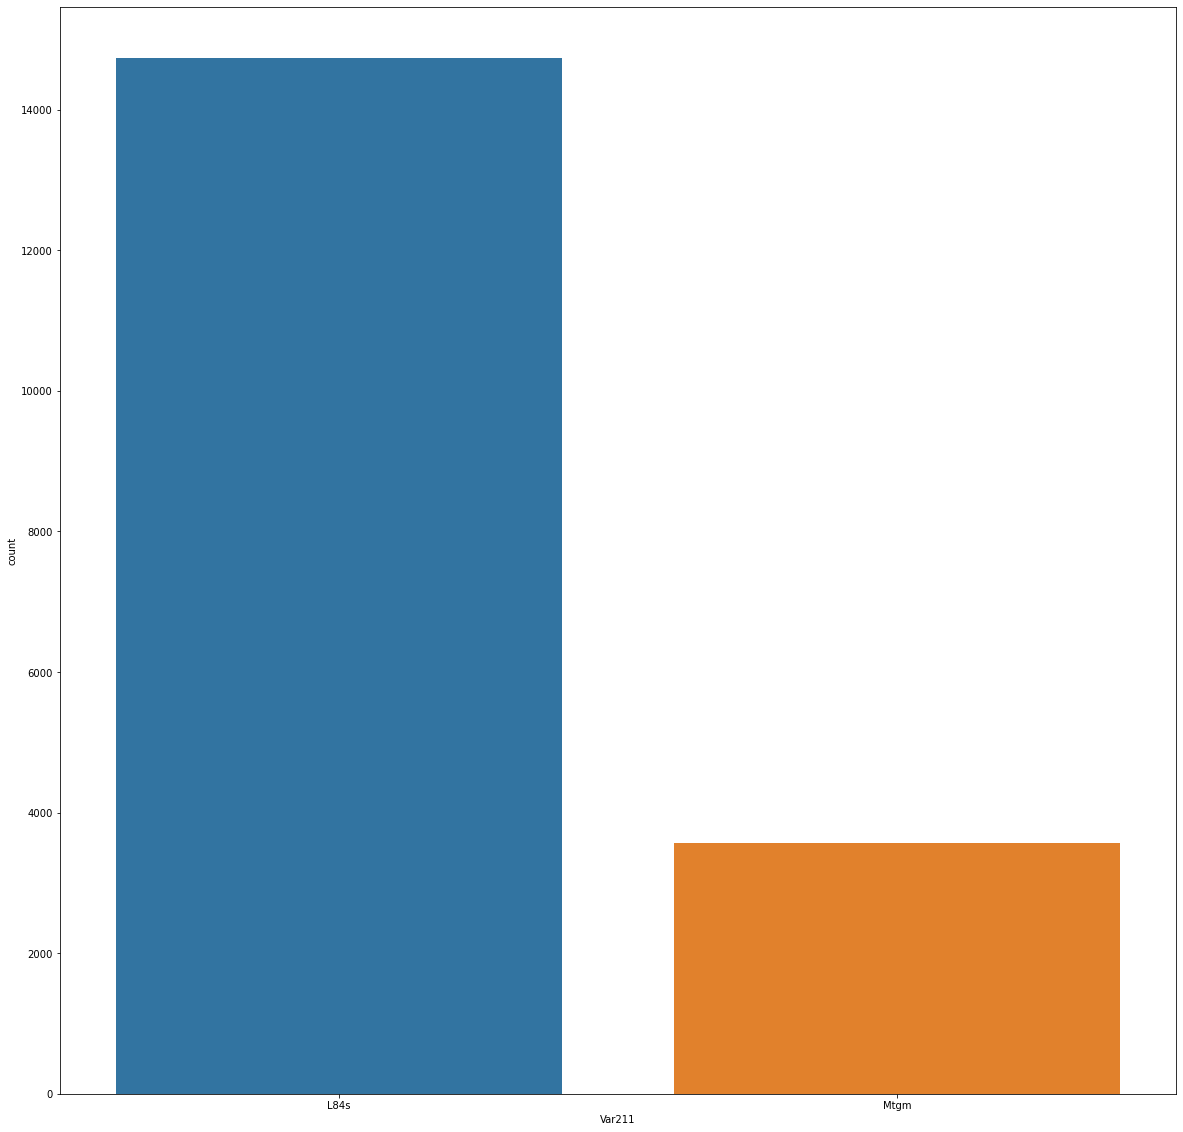

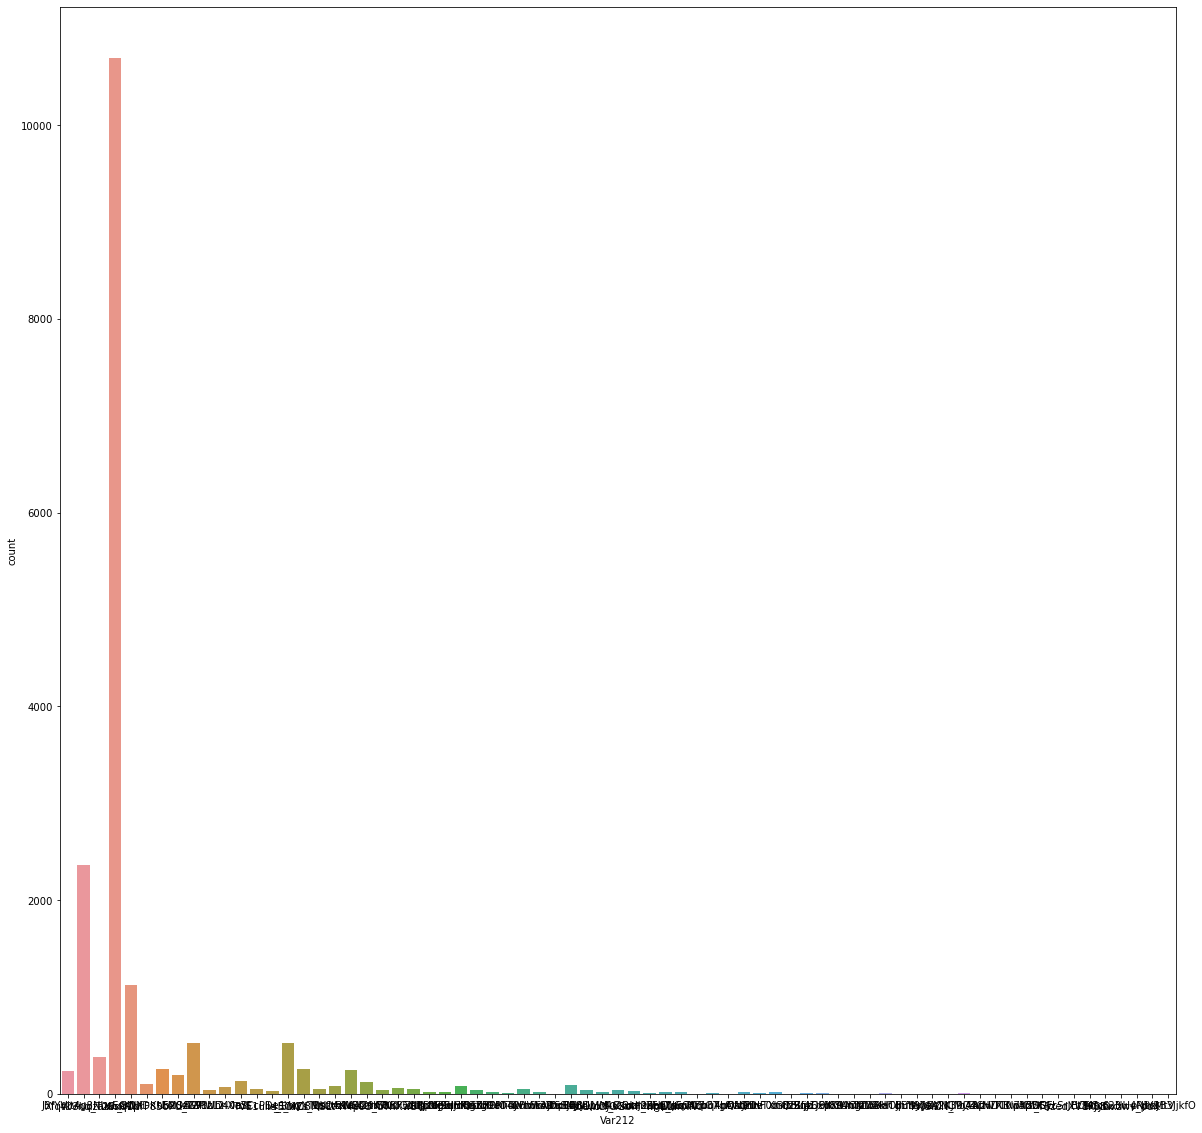

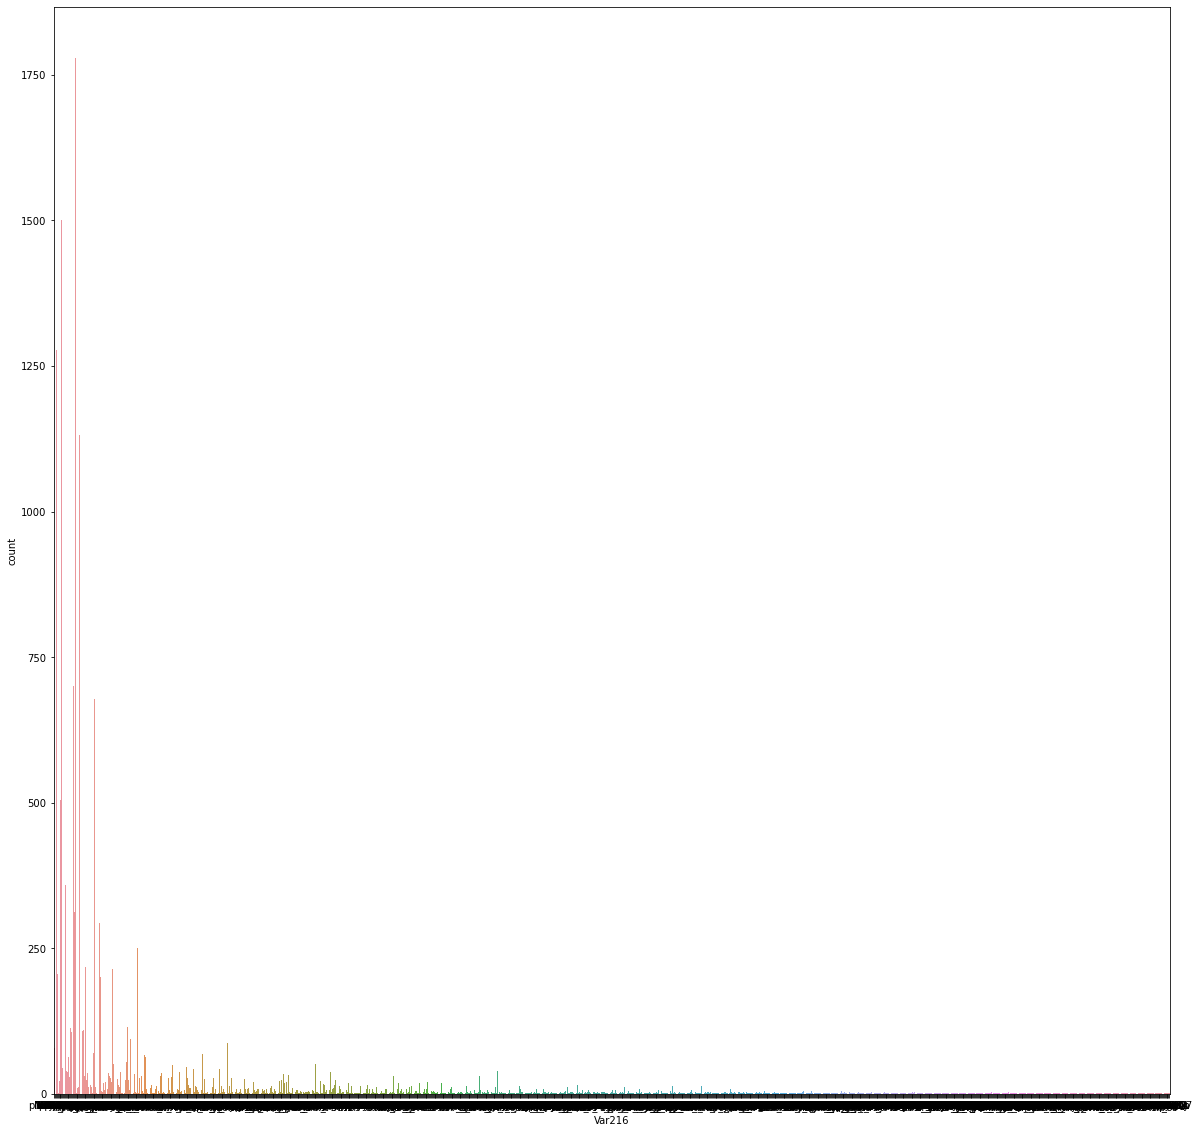

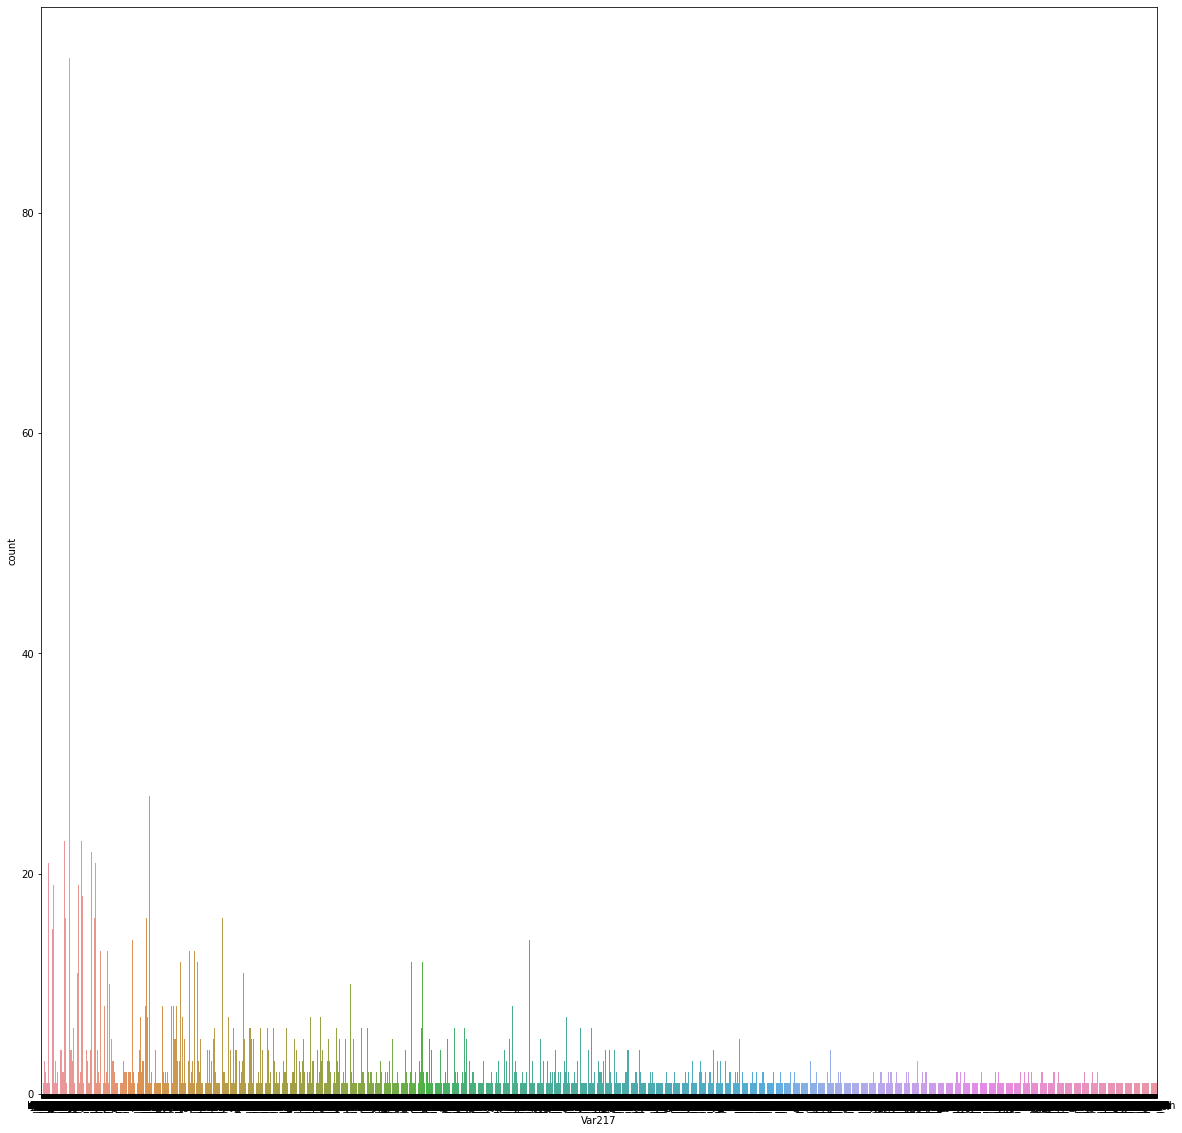

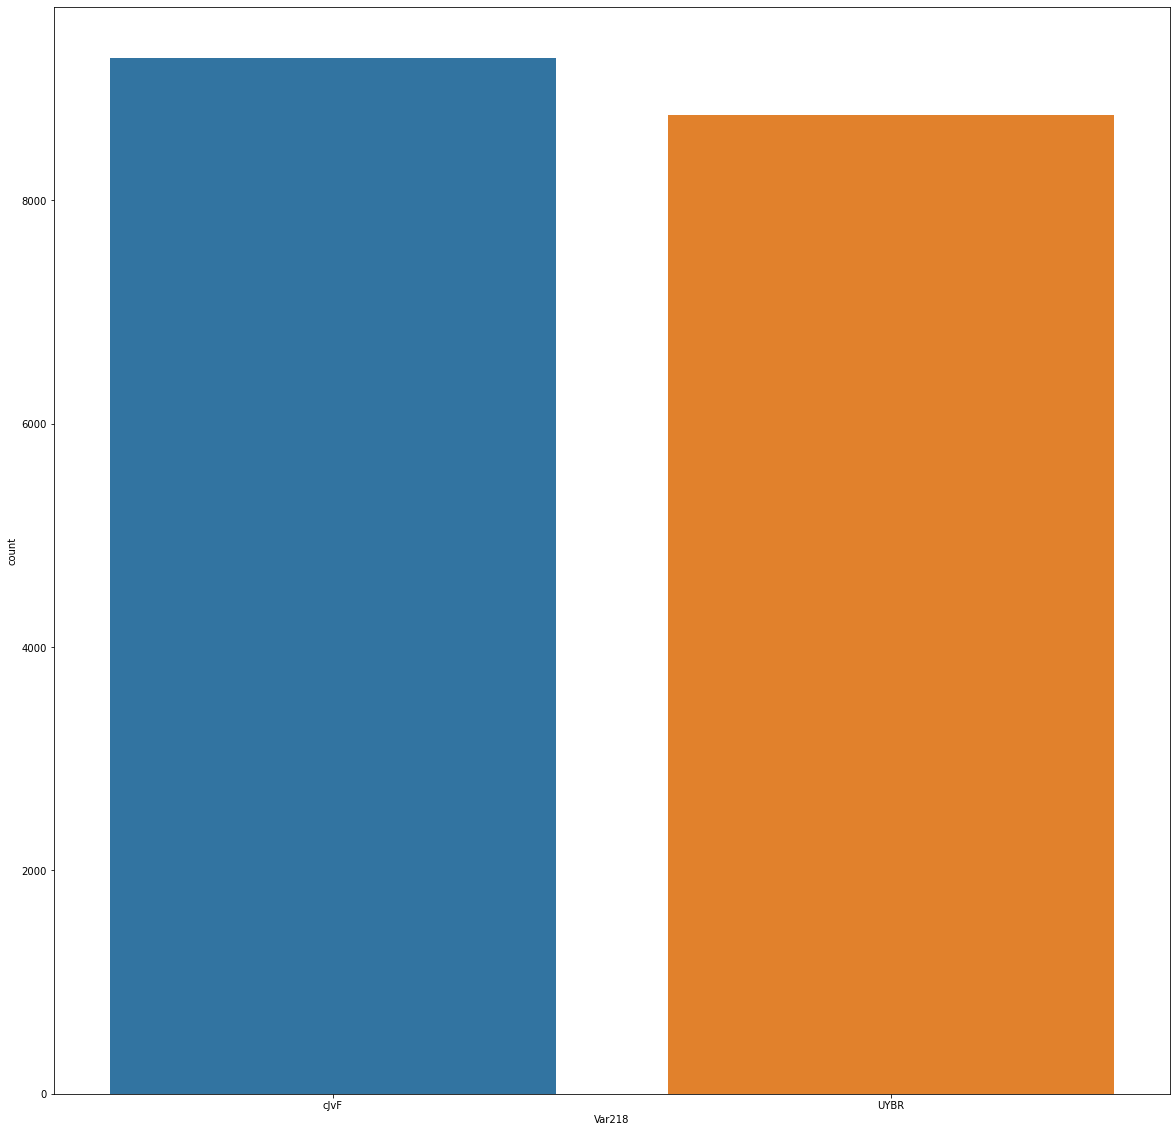

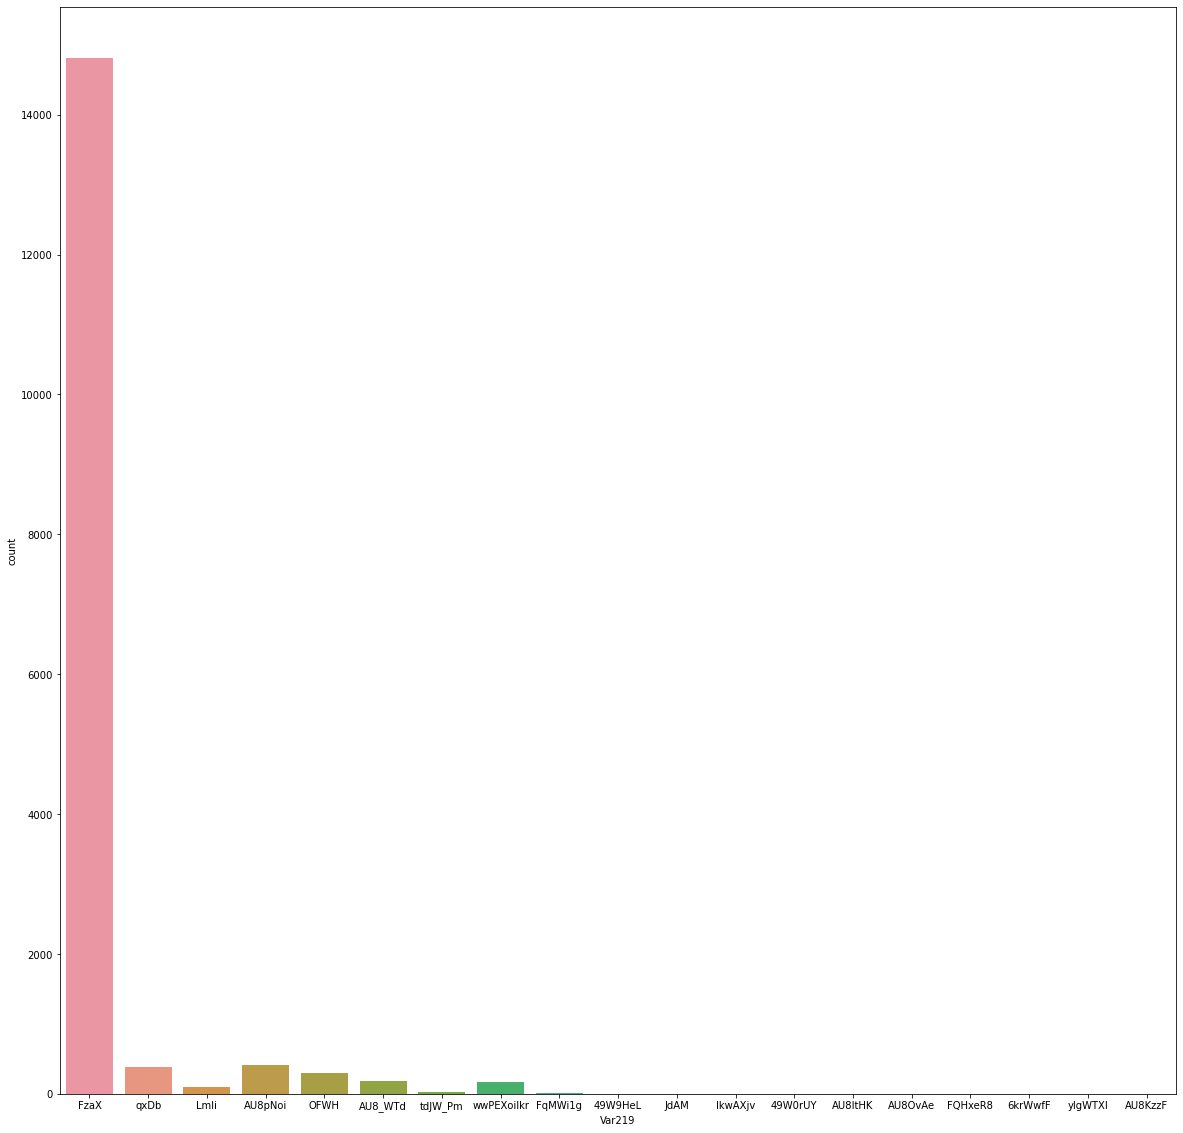

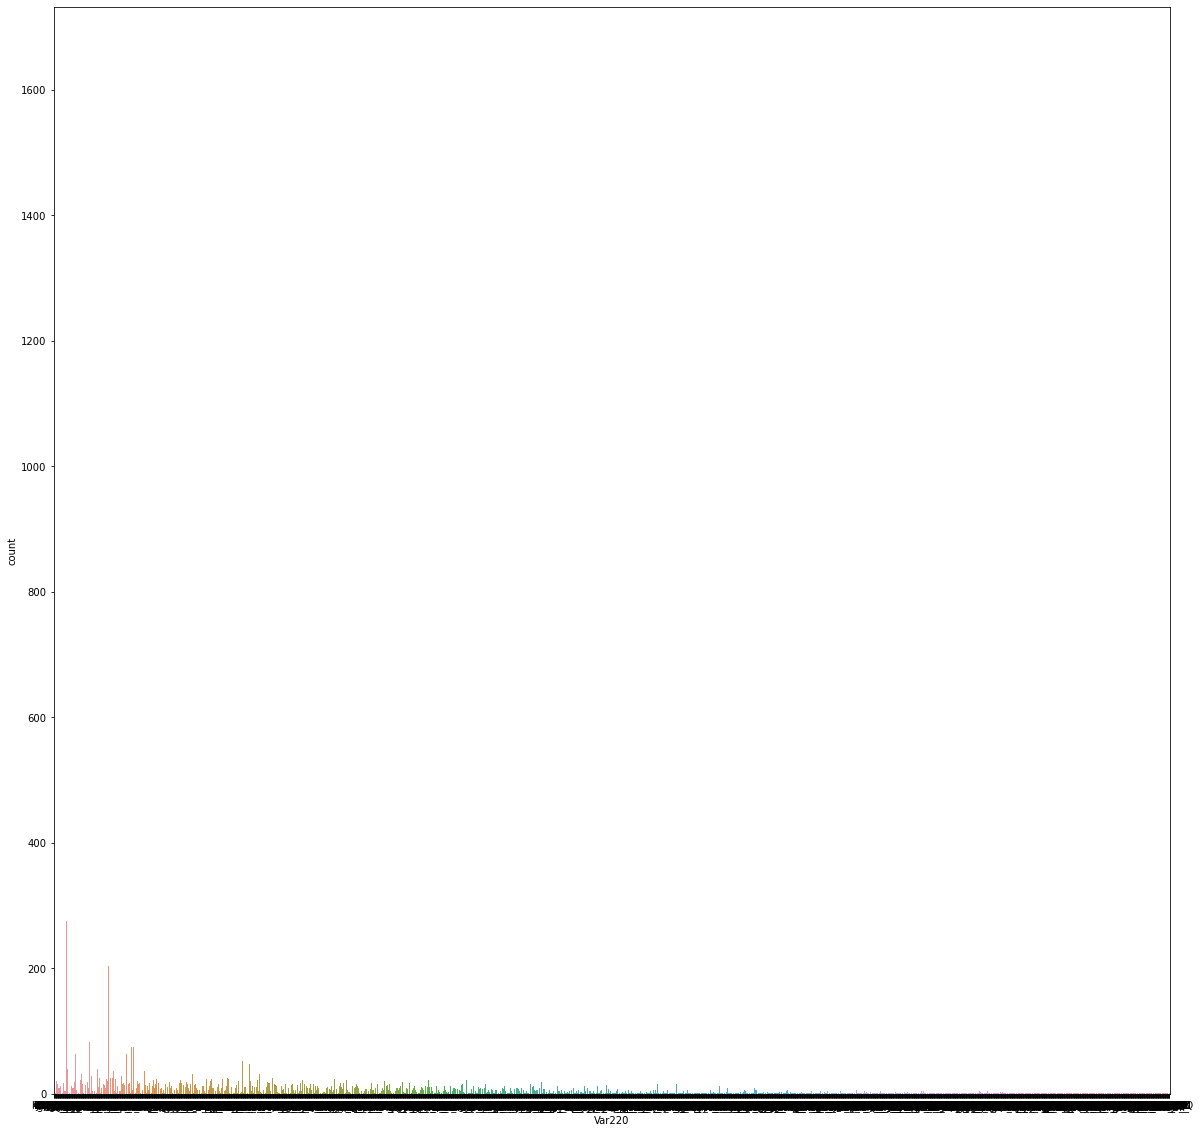

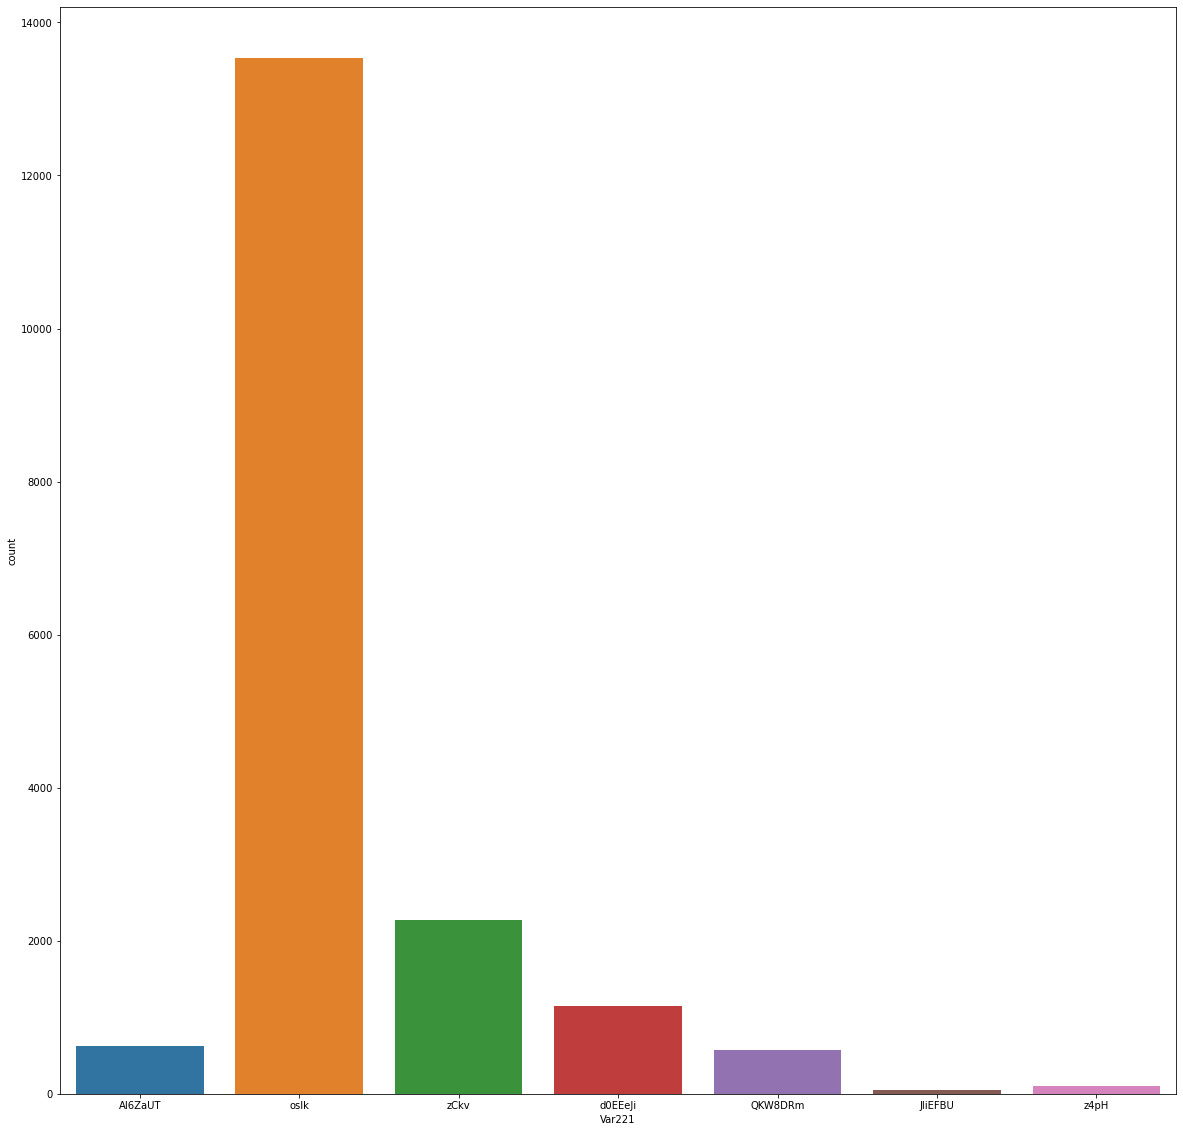

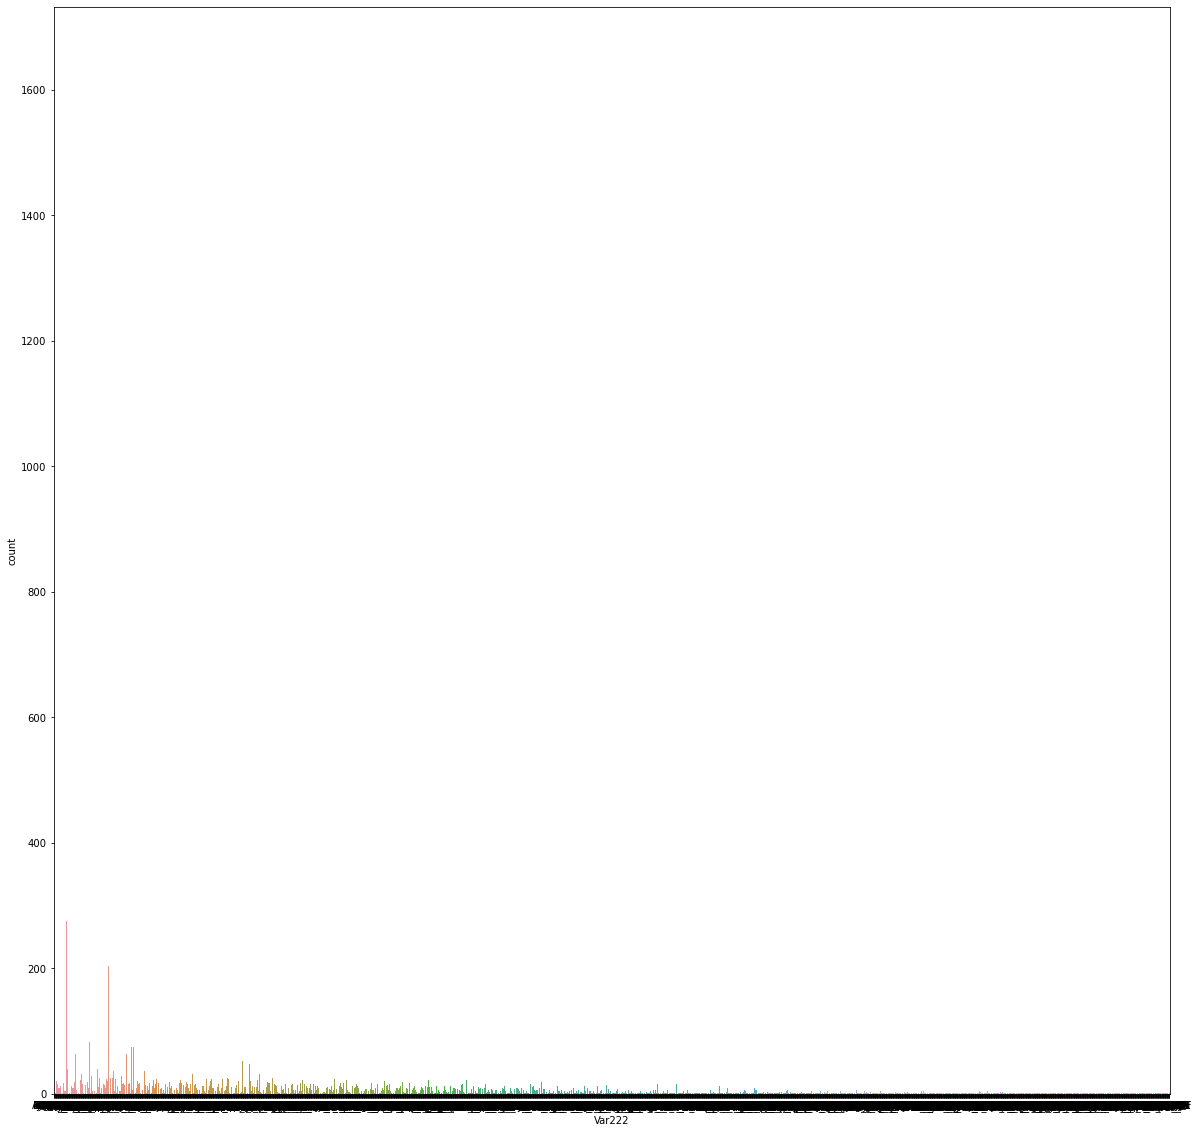

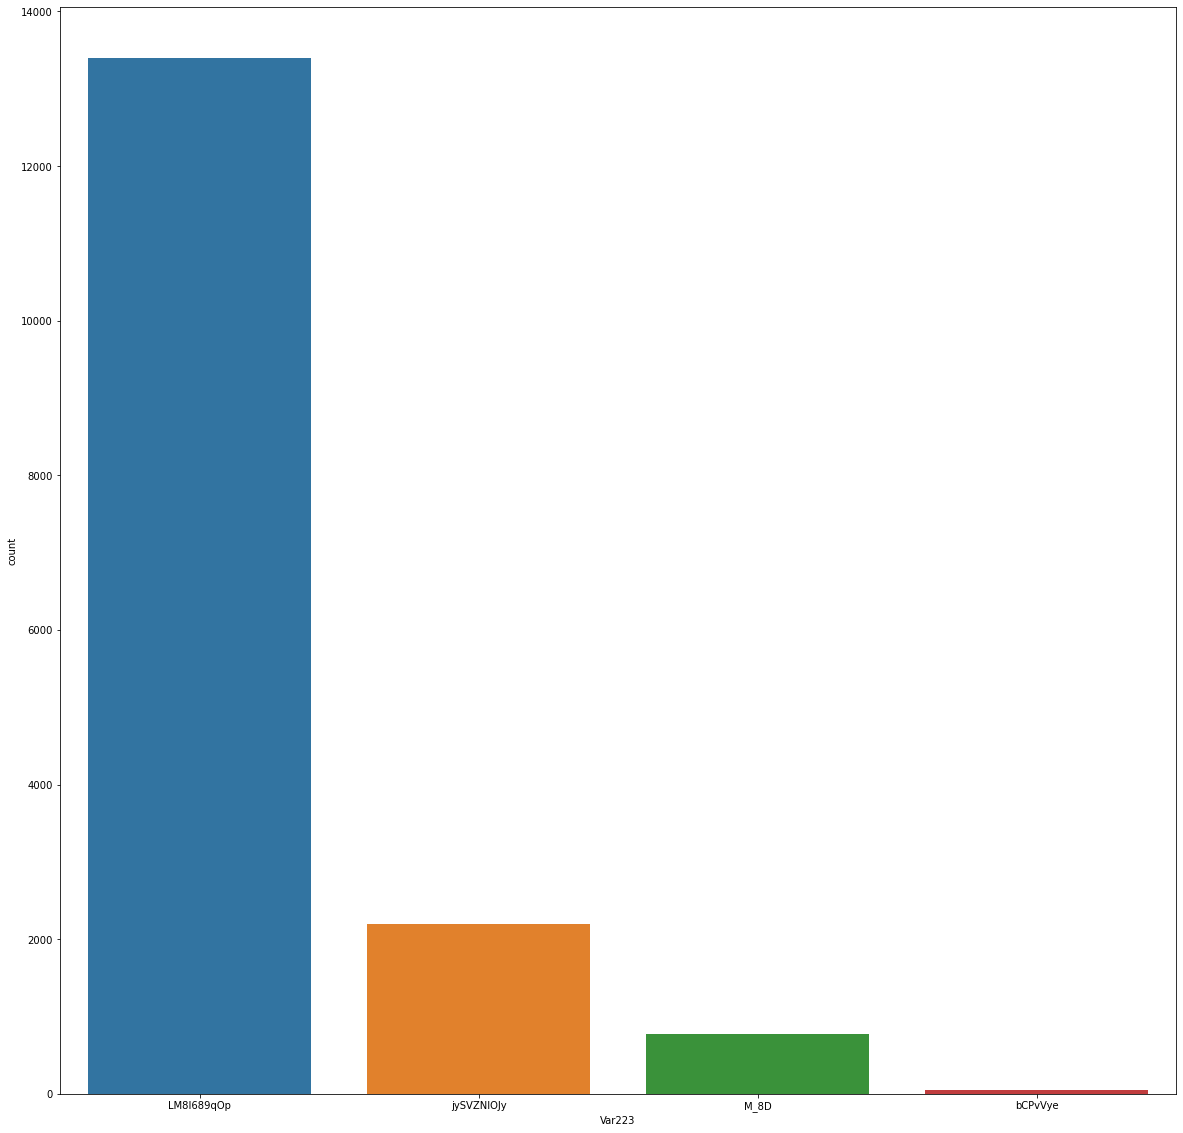

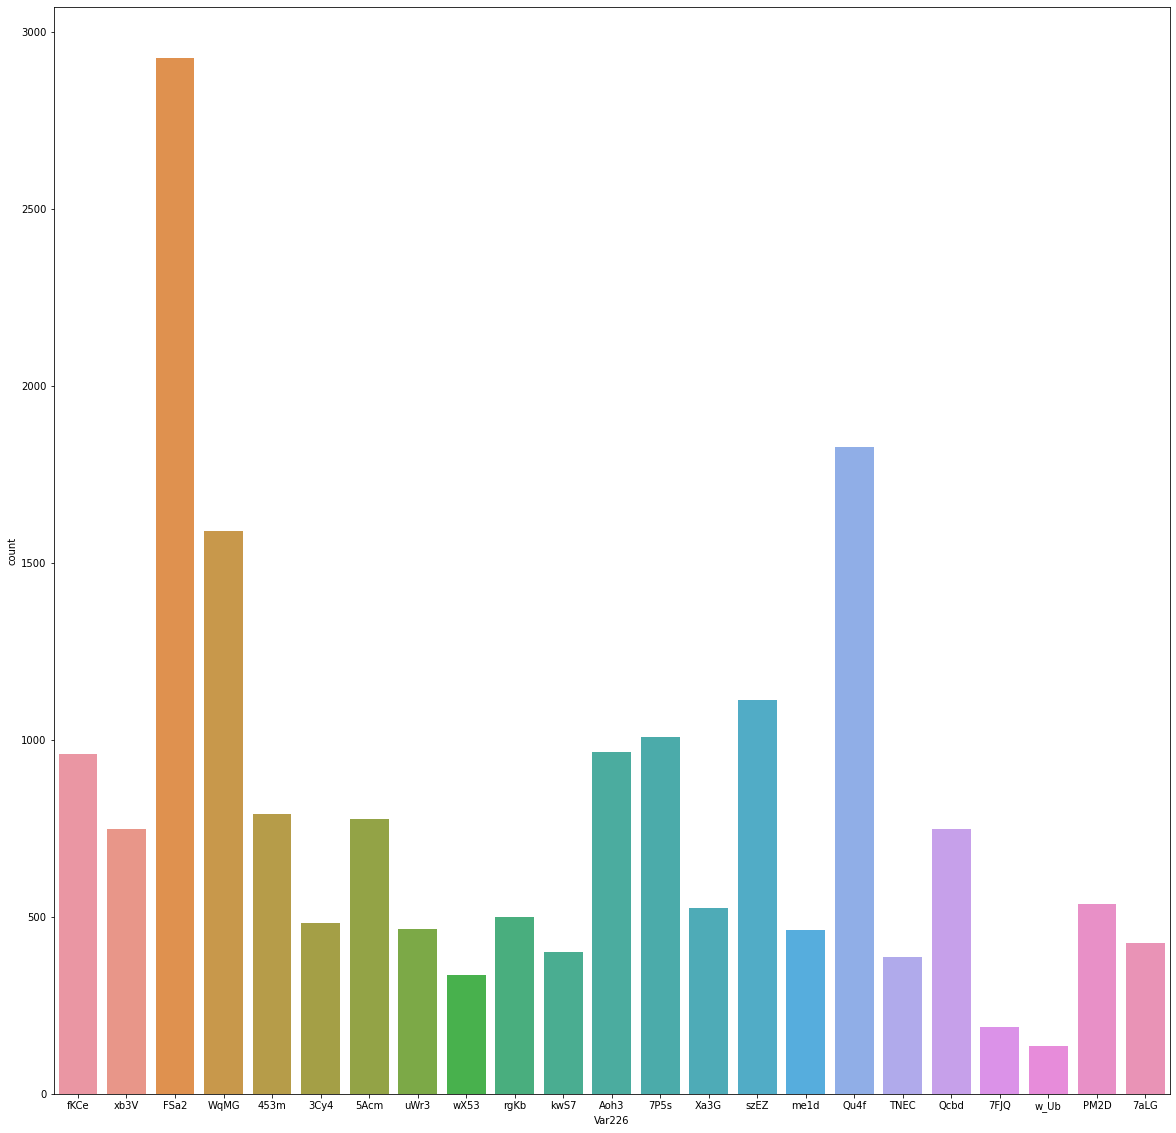

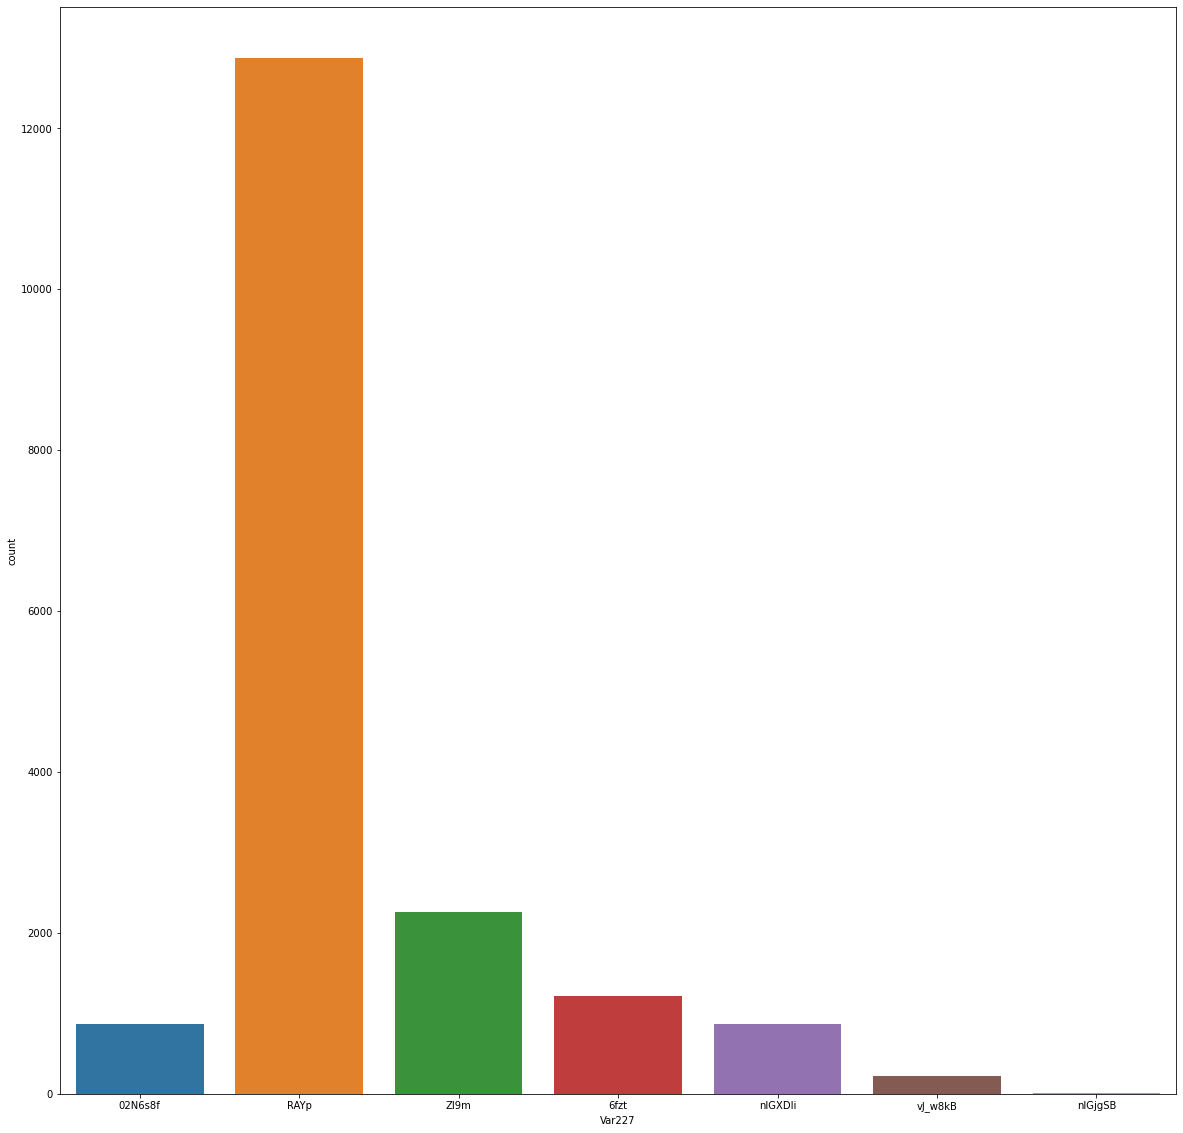

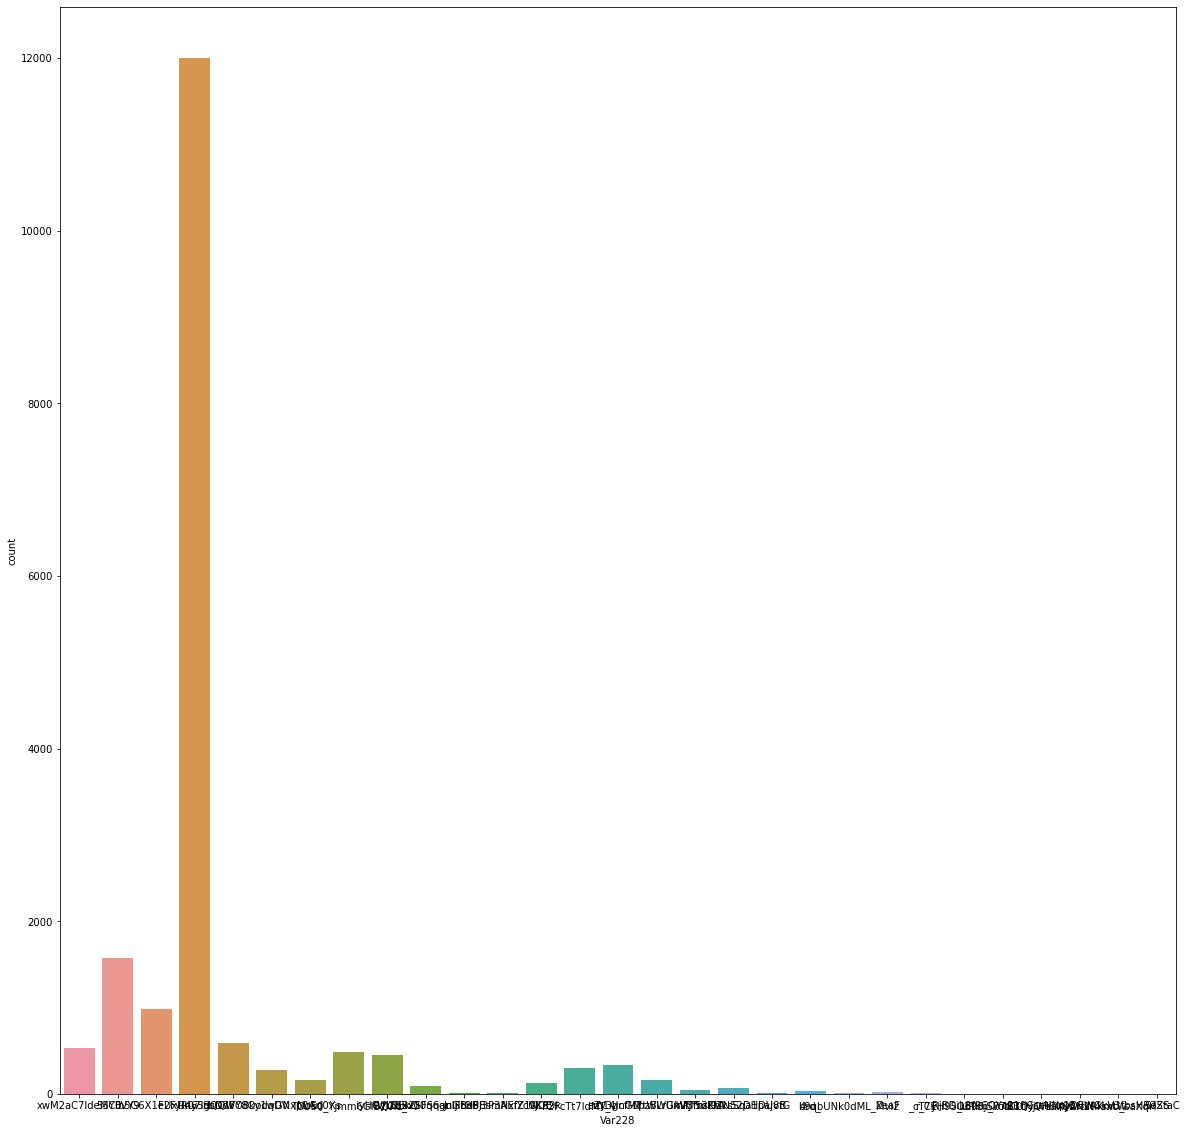

In [25]:
for name in right_cat_column:
    plt.figure(figsize=(20,20))
    sns.countplot(x=name, data=data[right_cat_column])

In [28]:
for check_name in ['Var196', 'Var195']:
    print(check_name)
    print(data[check_name].value_counts())
    

Var196
1K8T    18130
z3mO      159
JA1C        8
mKeq        1
Name: Var196, dtype: int64
Var195
taul                17562
LfvqpCtLOY            297
CiJDdr4TQ0rGERIS      203
ev6I                   70
CuXi4je                65
b_3Q                   24
I9xt3GDRhUK7p          24
I9xt3GMcxUnBZ          11
I9xt3GBDKUbd8           9
ArtjQZmIvr94p           6
ArtjQZ8ftr3NB           6
lSbpiq1                 4
hiMqnEM7VgIk4JUu        4
BNjsq81k1tWAYigY        3
bsZtYxFjzA              3
ZZBPiZh                 2
ArtjQZQO1r9fC           1
F1JQrEL                 1
CiJsoa4TQ0rGHlMp        1
TnJpfvsJgF              1
V10_0kx3ZF2we           1
Name: Var195, dtype: int64


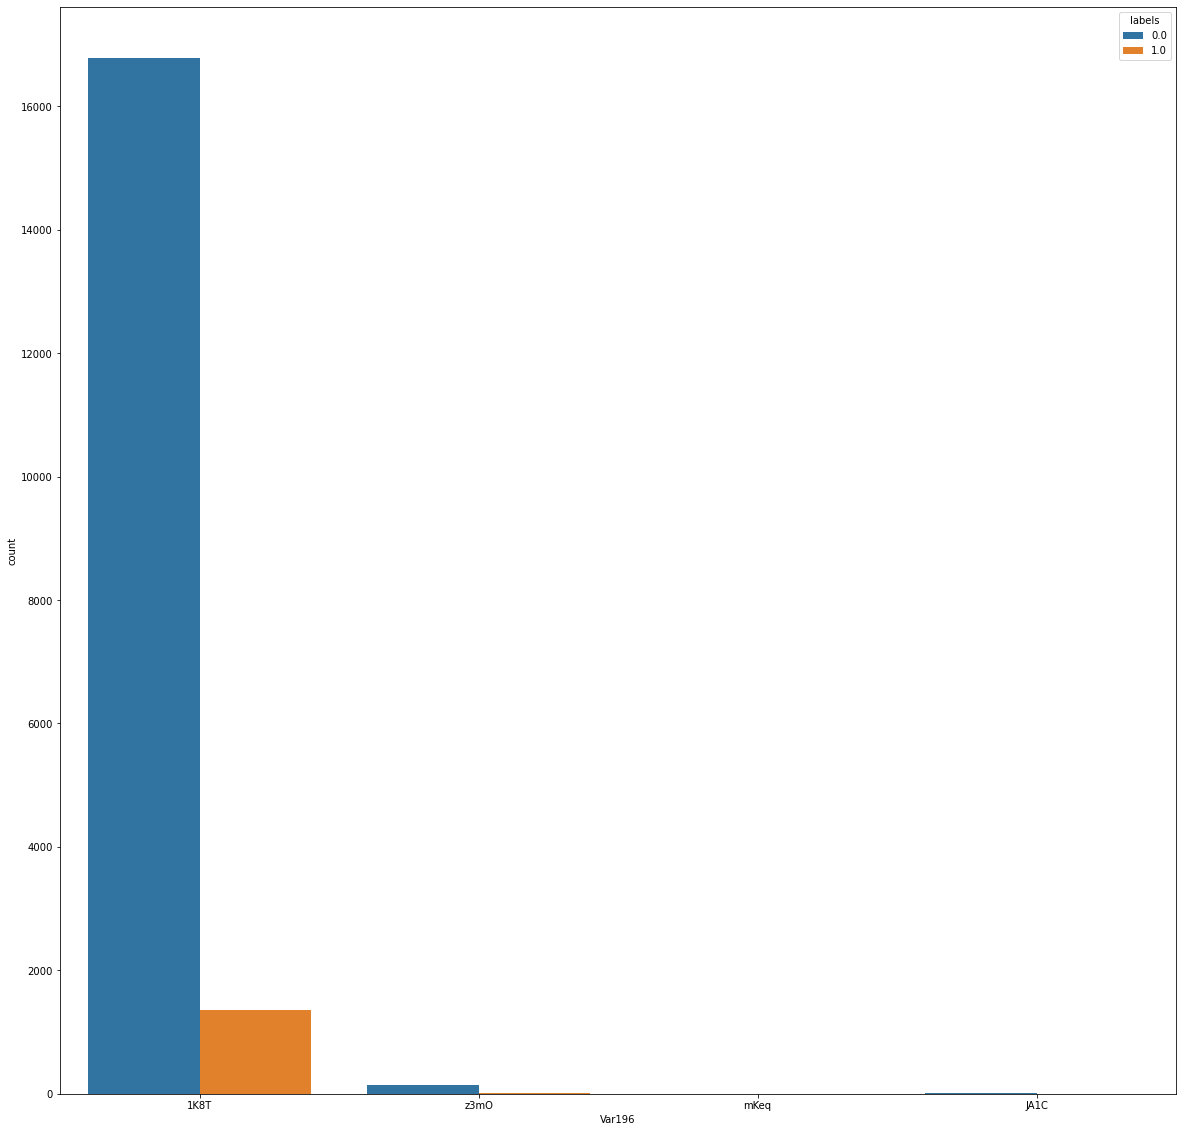

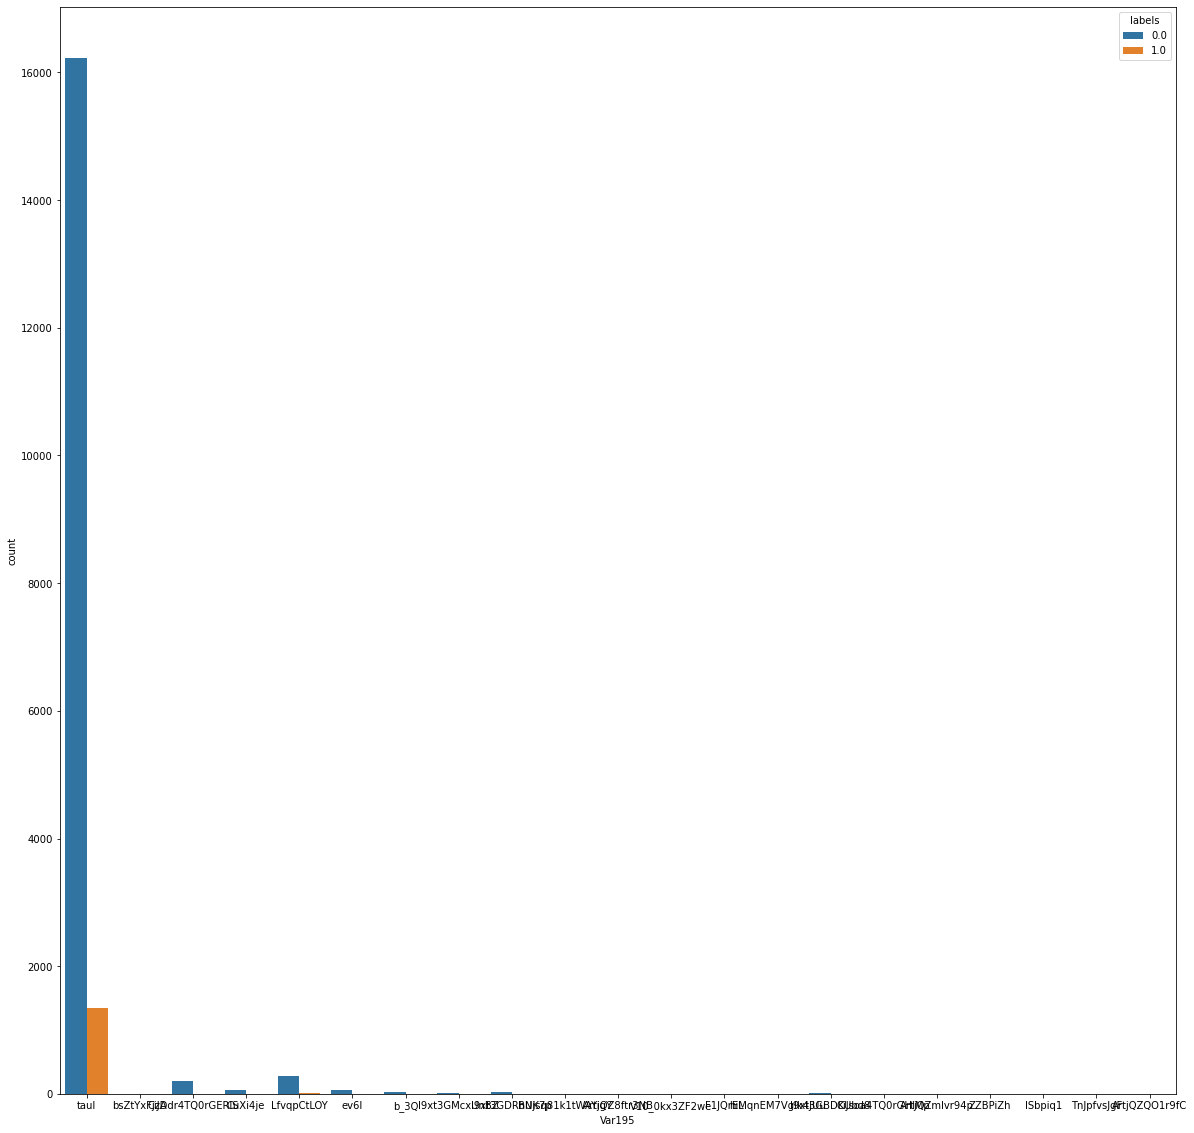

In [31]:
for check_name in ['Var196', 'Var195']:
    plt.figure(figsize=(20,20))
    sns.countplot(x=check_name, data=data[right_cat_column], hue = labels)

this feature is almost constant, it should drop from data